## Mulitple Different Time Series Anomaly Detection Methods

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
#from statsmodels.graphics.tsaplots import plot_acf
import math
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.ensemble import IsolationForest
# import keras
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.regularizers import l2
import random
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
#from tabulate import tabulate

In [ ]:
#Read in the data
df_swat = pd.read_excel("SWaT_dataset_Jul 19 v2.xlsx", header=2)

# Make the timestamp column more useful
timestamp_col = [col for col in df_swat.columns if 'time' in col.lower()][0]
df_swat['timestamp'] = pd.to_datetime(df_swat[timestamp_col], utc=True, format='mixed')
df_swat = df_swat.sort_values('timestamp')
df_swat.replace({'ON': 1, 'OFF': 0, 'Open': 1, 'Close': 0, 'Active': 1, 'Inactive': 0}, inplace=True)

# Identify the attacks as specified by the creators of the data
attack_intervals = [
    ('2019-07-20 07:08:46+00:00', '2019-07-20 07:10:31+00:00'), # Attack 1
    ('2019-07-20 07:15:00+00:00', '2019-07-20 07:19:32+00:00'), # Attack 2
    ('2019-07-20 07:26:57+00:00', '2019-07-20 07:30:48+00:00'), # Attack 3
    ('2019-07-20 07:38:50+00:00', '2019-07-20 07:46:20+00:00'), # Attack 4
    ('2019-07-20 07:54:00+00:00', '2019-07-20 07:56:00+00:00'), # Attack 5
    ('2019-07-20 08:02:56+00:00', '2019-07-20 08:16:18+00:00'), # Attack 6
]

# Create an is_attack column for later analysis
df_swat['is_attack'] = 0
for start, end in attack_intervals:
    mask = (df_swat['timestamp'] >= start) & (df_swat['timestamp'] <= end)
    df_swat.loc[mask, 'is_attack'] = 1

/tmp/ipython-input-3833955395.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_swat.replace({'ON': 1, 'OFF': 0, 'Open': 1, 'Close': 0, 'Active': 1, 'Inactive': 0}, inplace=True)


In [ ]:
# Define the chronological boundaries for our three sets
TRAIN_START = '2019-07-20 04:30:00+00:00'
TRAIN_END = attack_intervals[0][0]

# We'll split the validation and test sets after the 3rd attack
VALIDATION_TEST_SPLIT = attack_intervals[2][1]

# Training Set: All data from the start until the first attack begins
train = df_swat[
    (df_swat['timestamp'] >= TRAIN_START) &
    (df_swat['timestamp'] < TRAIN_END)
].copy()

# Validation Set: All data from the start of the first attack up to our split point
validation = df_swat[
    (df_swat['timestamp'] >= TRAIN_END) &
    (df_swat['timestamp'] <= VALIDATION_TEST_SPLIT)
].copy()

# Test Set: All data after the split point until the end of the dataset
test = df_swat[
    (df_swat['timestamp'] > VALIDATION_TEST_SPLIT)
].copy()


In [ ]:
# Original numeric feature list creation
features_original = [c for c in train.columns if c not in ['timestamp', 'is_attack']]

# Find and remove the constant features
constant_features = [col for col in features_original if train[col].nunique() == 1]

# The CORRECTED feature list, excluding the silent sensors
features_final = [col for col in features_original if col not in constant_features]

# Initialize and fit the scaler
scaler = MinMaxScaler()

# Transform all splits using the same scaler
train_scaled = scaler.fit_transform(train[features_final])
validation_scaled = scaler.transform(validation[features_final])
test_scaled = scaler.transform(test[features_final])

# Extract labels (for evaluation)
y_train = train['is_attack'].values.astype('float32')
y_val = validation['is_attack'].values.astype('float32')
y_test = test['is_attack'].values.astype('float32')

# Extract timestamps for visualization
timestamps_train = train['timestamp'].values
timestamps_val = validation['timestamp'].values
timestamps_test = test['timestamp'].values

# Convert scaled features and labels to PyTorch tensors
train_tensor = torch.from_numpy(train_scaled.astype('float32'))
validation_tensor = torch.from_numpy(validation_scaled.astype('float32'))
test_tensor = torch.from_numpy(test_scaled.astype('float32'))

y_train_tensor = torch.from_numpy(y_train)
y_val_tensor = torch.from_numpy(y_val)
y_test_tensor = torch.from_numpy(y_test)


In [ ]:
def convert_labels_to_windows(data, n_window):
    """
    Creates windowed labels. A window is 1 if any
    label in it is 1.
    """
    windows = []
    w_size = n_window

    # Iterate from the first valid window end-point
    for i in range(w_size - 1, len(data)):
        # The window of labels
        w = data[i - w_size + 1 : i + 1]

        # Check if ANY label in the window is 1
        window_label = 1 if (torch.sum(w) > 0) else 0
        windows.append(window_label)

    # We are returning a 1D tensor of labels
    return torch.tensor(windows, dtype=torch.float32)

def convert_to_windows(data, n_window):
    """
    Creates standard sliding windows, no padding.
    """
    windows = []
    w_size = n_window

    # Iterate from the first valid window end-point
    for i in range(w_size - 1, len(data)):
        # The window of data
        w = data[i - w_size + 1 : i + 1]
        windows.append(w)

    # Return (num_windows, window_size, num_features)
    return torch.stack(windows)

In [ ]:
n_window = 30

# --- Create Data Windows ---
# This will create (N - n_window + 1) windows
train_windows = convert_to_windows(train_tensor, n_window)
validation_windows = convert_to_windows(validation_tensor, n_window)
test_windows = convert_to_windows(test_tensor, n_window)

# --- Create Label Windows ---
# This will also create (N - n_window + 1) labels
y_train_window_labels = convert_labels_to_windows(y_train_tensor, n_window)
y_val_window_labels = convert_labels_to_windows(y_val_tensor, n_window)
y_test_window_labels = convert_labels_to_windows(y_test_tensor, n_window)

# --- Check your shapes ---
# train_windows.shape[0] will now equal y_train_window_labels.shape[0]
print(f"Test windows shape: {test_windows.shape}")
print(f"Test labels shape: {y_test_window_labels.shape}")

Test windows shape: torch.Size([4122, 30, 39])
Test labels shape: torch.Size([4122])


#EDA

In [ ]:
# Split the data into normal vs. attack portions to find differences
normal_df = df_swat[df_swat['is_attack'] == 0]
attack_df = df_swat[df_swat['is_attack'] == 1]

In [ ]:
# Summary stats for normal data
normal_stats = normal_df[features_final].describe().T
attack_stats = attack_df[features_final].describe().T

# Find differences
diff_stats = attack_stats[['mean', 'std', 'min', 'max']] - normal_stats[['mean', 'std', 'min', 'max']]

diff_stats


,mean,std,min,max
value,0.211989,0.174665,0.000000,-0.006405
value.1,13.136081,-2.616923,4.435547,-3.336457
value.2,0.039328,0.047298,0.000000,0.000000
value.3,-0.070995,-0.256826,0.000000,-1.000000
value.4,-0.032120,-0.009102,0.000000,0.000000
value.6,-10.988705,1.047093,-2.243012,-0.544735
value.7,-0.160687,-0.004481,0.062164,-0.082991
value.8,-2.156179,0.600354,35.016663,-4.178406
value.9,-0.077348,-0.024513,0.000256,-0.004870
value.14,-0.031702,-0.005196,0.000000,0.000000


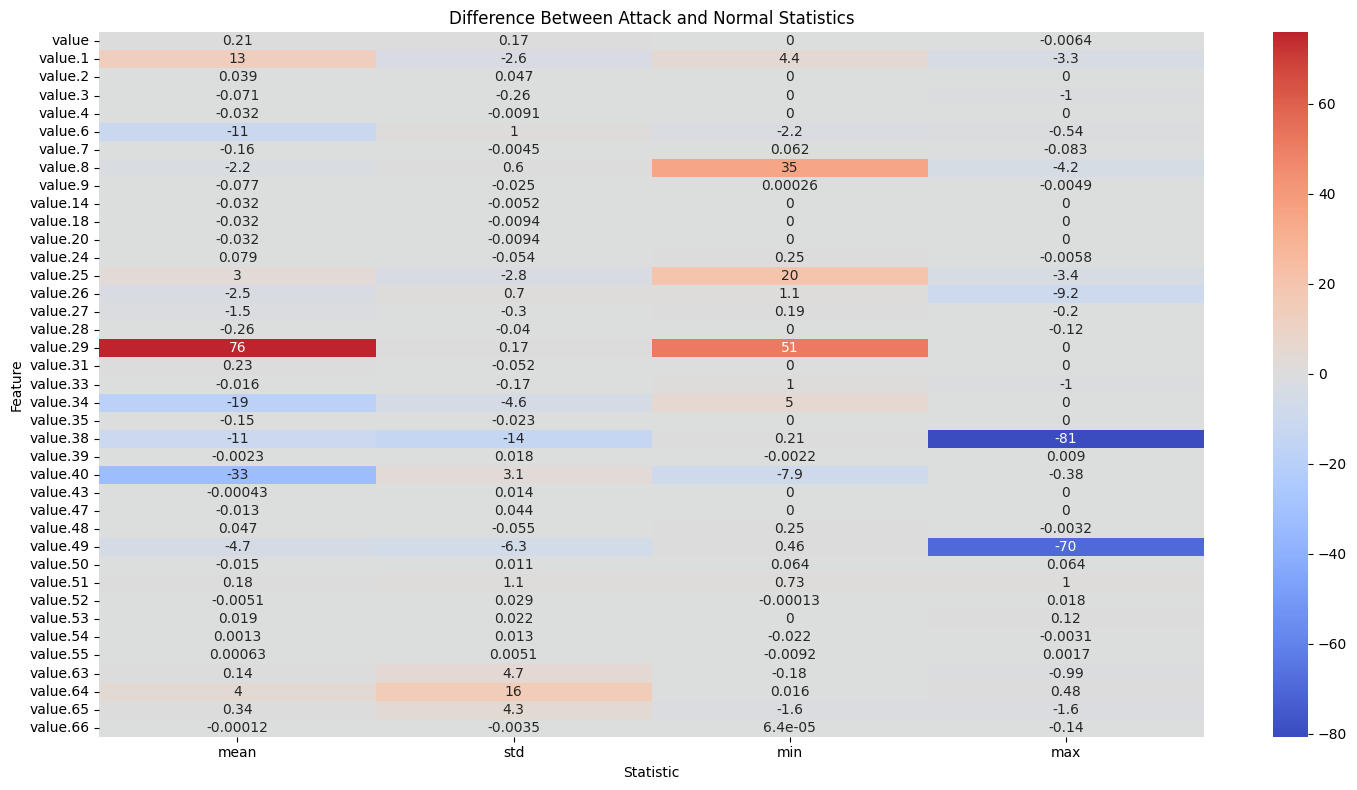

In [ ]:
plt.figure(figsize=(15, 8))
sns.heatmap(diff_stats, annot=True, cmap='coolwarm', center=0)
plt.title('Difference Between Attack and Normal Statistics')
plt.xlabel('Statistic')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


To better understand the differences between normal and attack conditions, summary statistics (mean, standard deviation, minimum, and maximum) were computed for each feature and visualized as a heatmap of their differences. The resulting visualization revealed several clear patterns. A subset of features—most notably value.29 and value.1—showed large positive shifts in mean and maximum values during attacks, indicating substantial increases in their magnitudes under anomalous conditions. In contrast, features such as value.38, value.40, and value.49 exhibited pronounced decreases in both mean and maximum values, suggesting suppressed or degraded behavior in response to attacks. Additionally, features like value.63, value.65, and value.66 demonstrated increased variability, reflected in higher standard deviations, implying that attack periods introduce greater instability to these signals. The majority of remaining features showed minimal statistical change, suggesting that only a small subset carries strong discriminative information for detecting attack events.

/usr/local/lib/python3.12/dist-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')


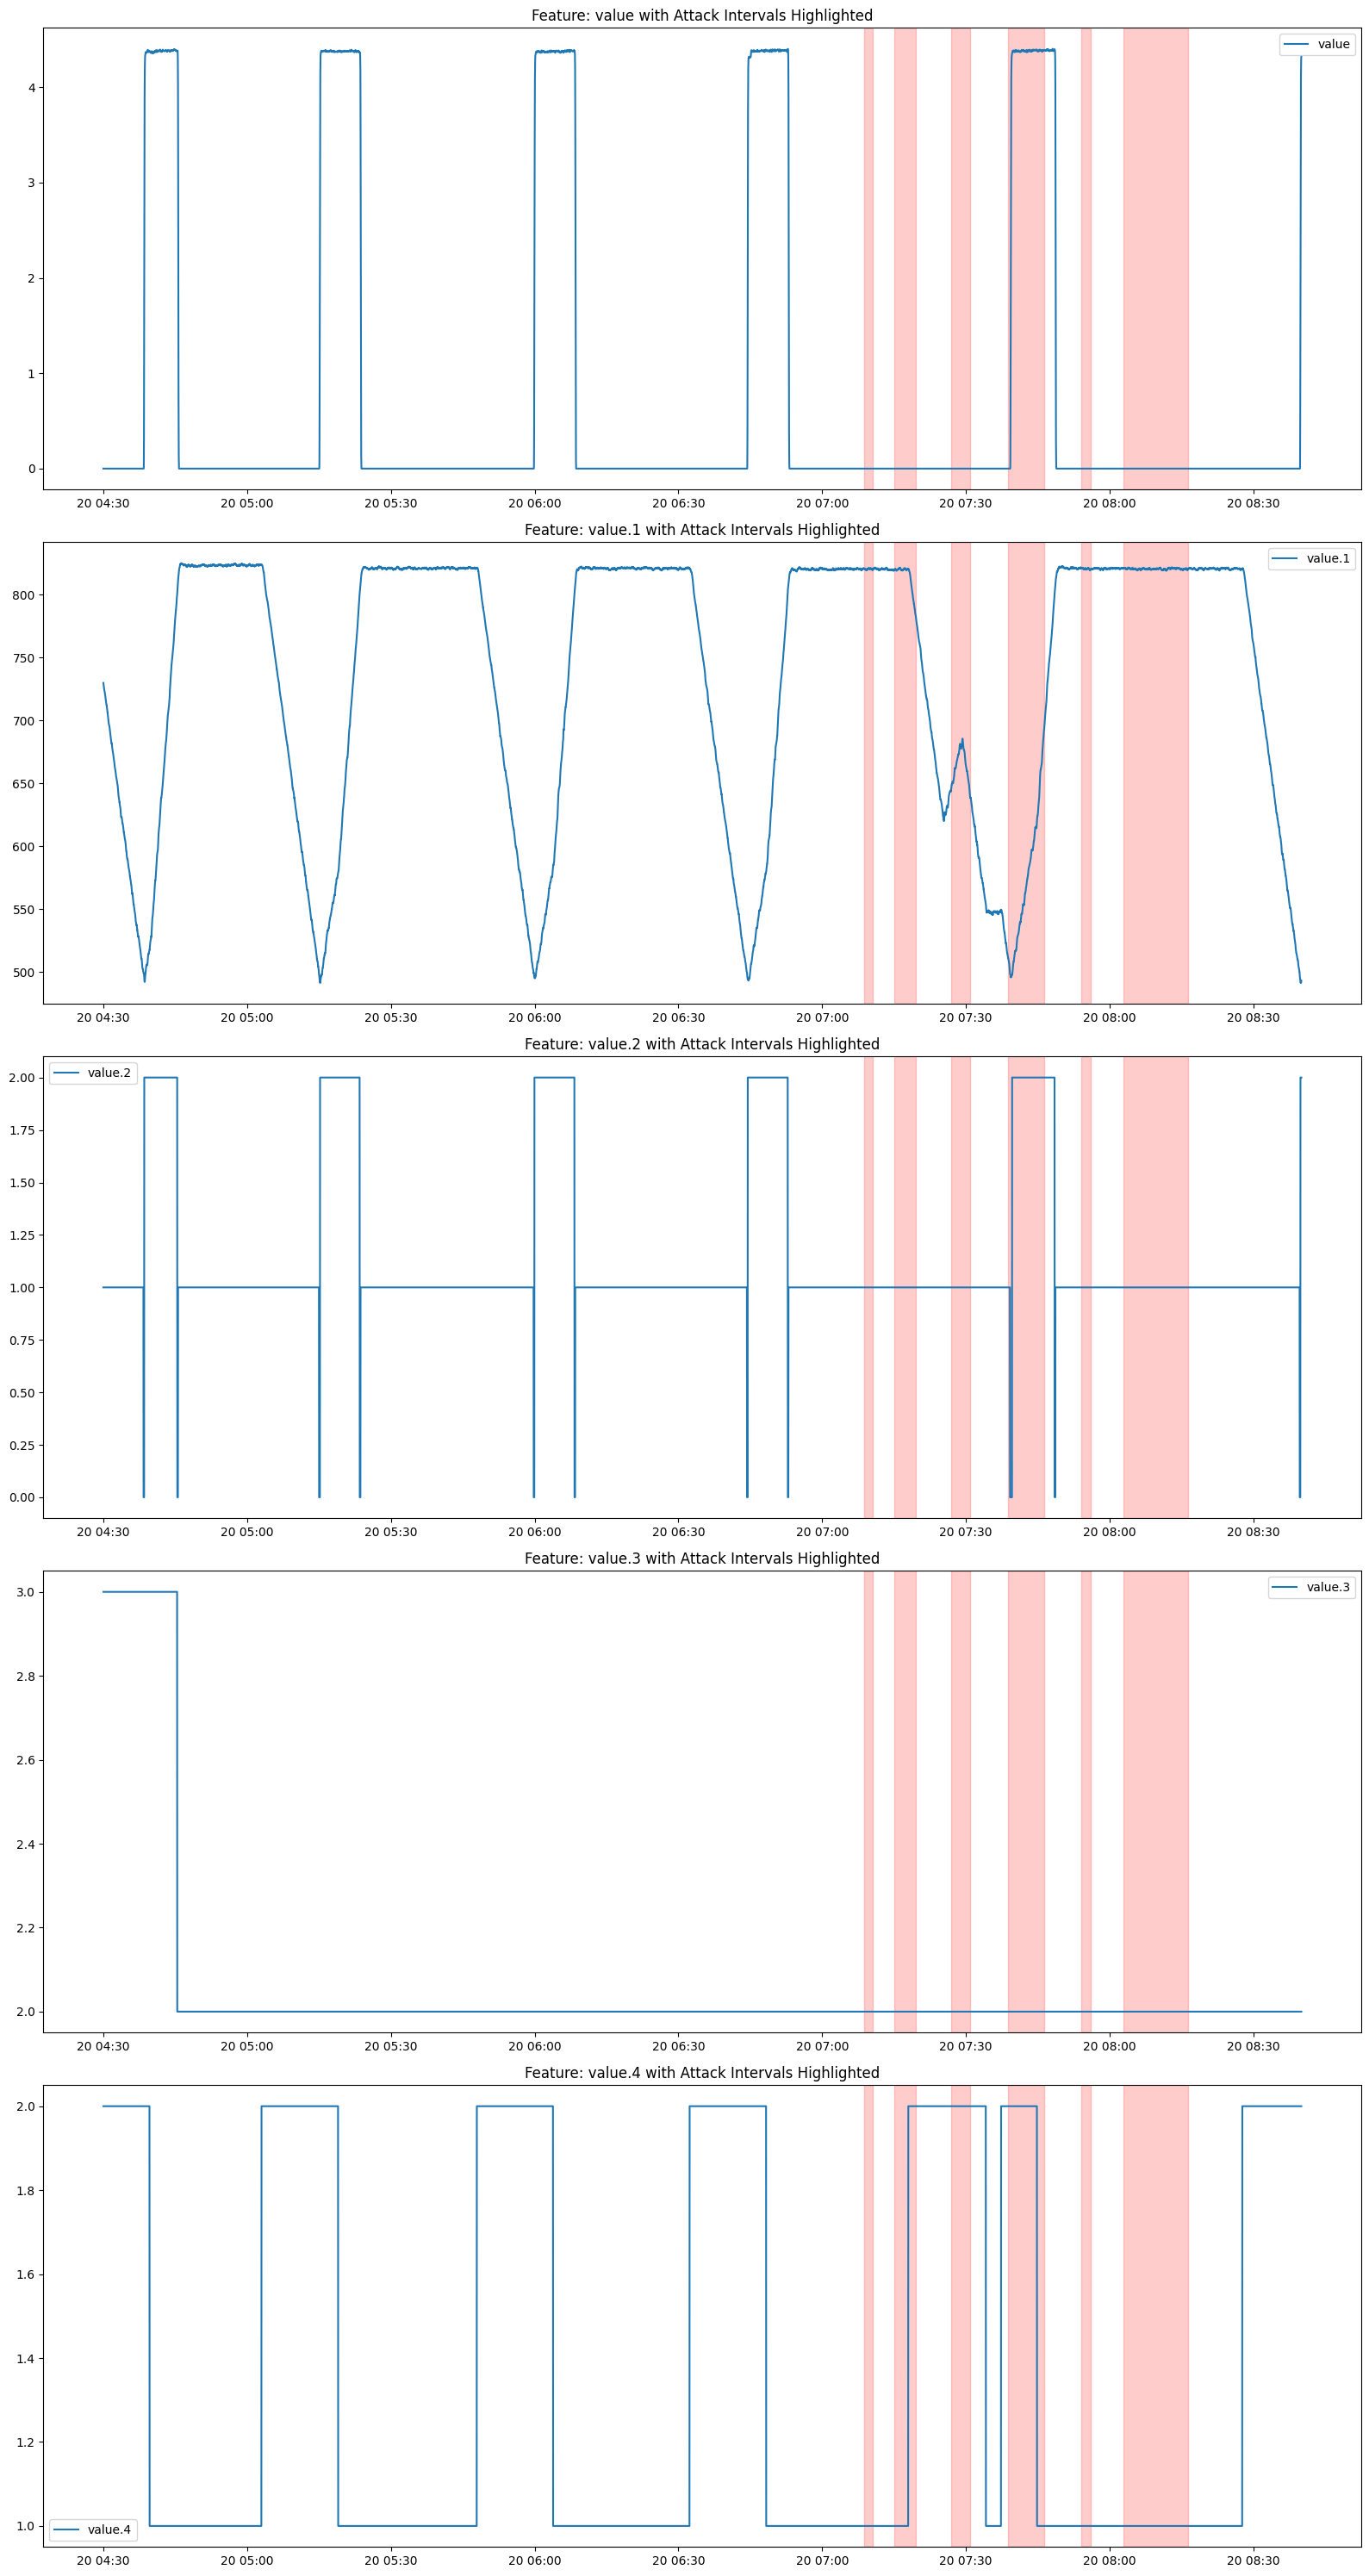

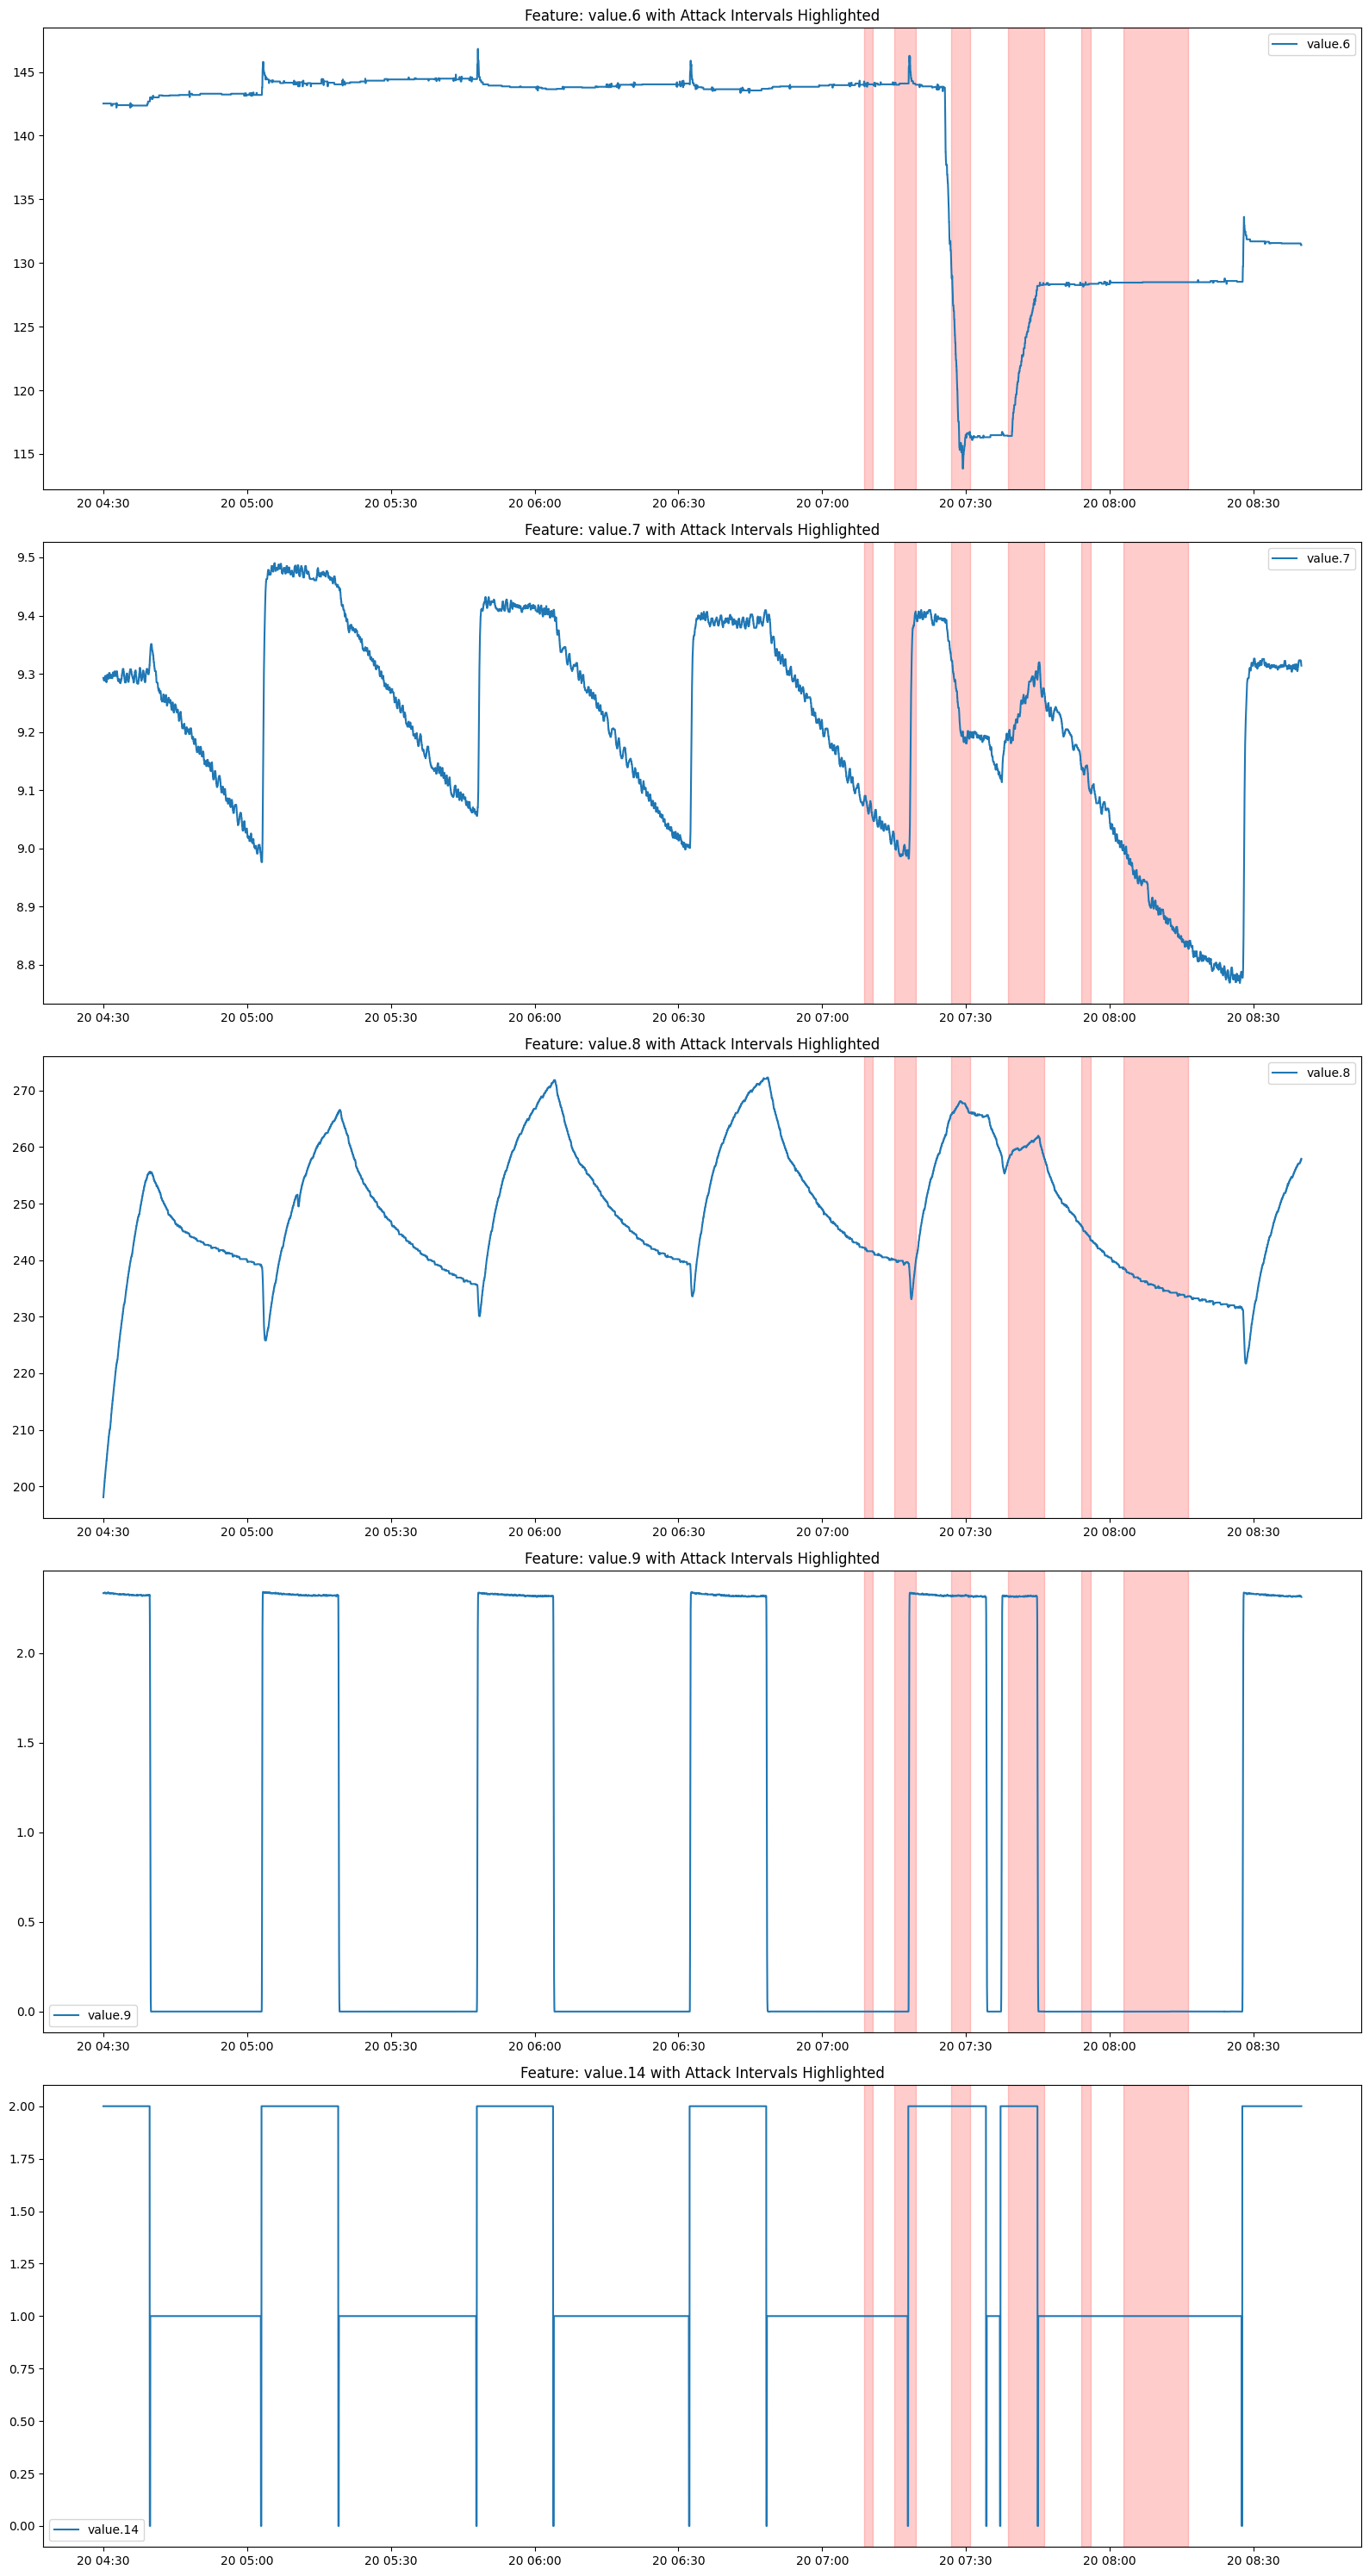

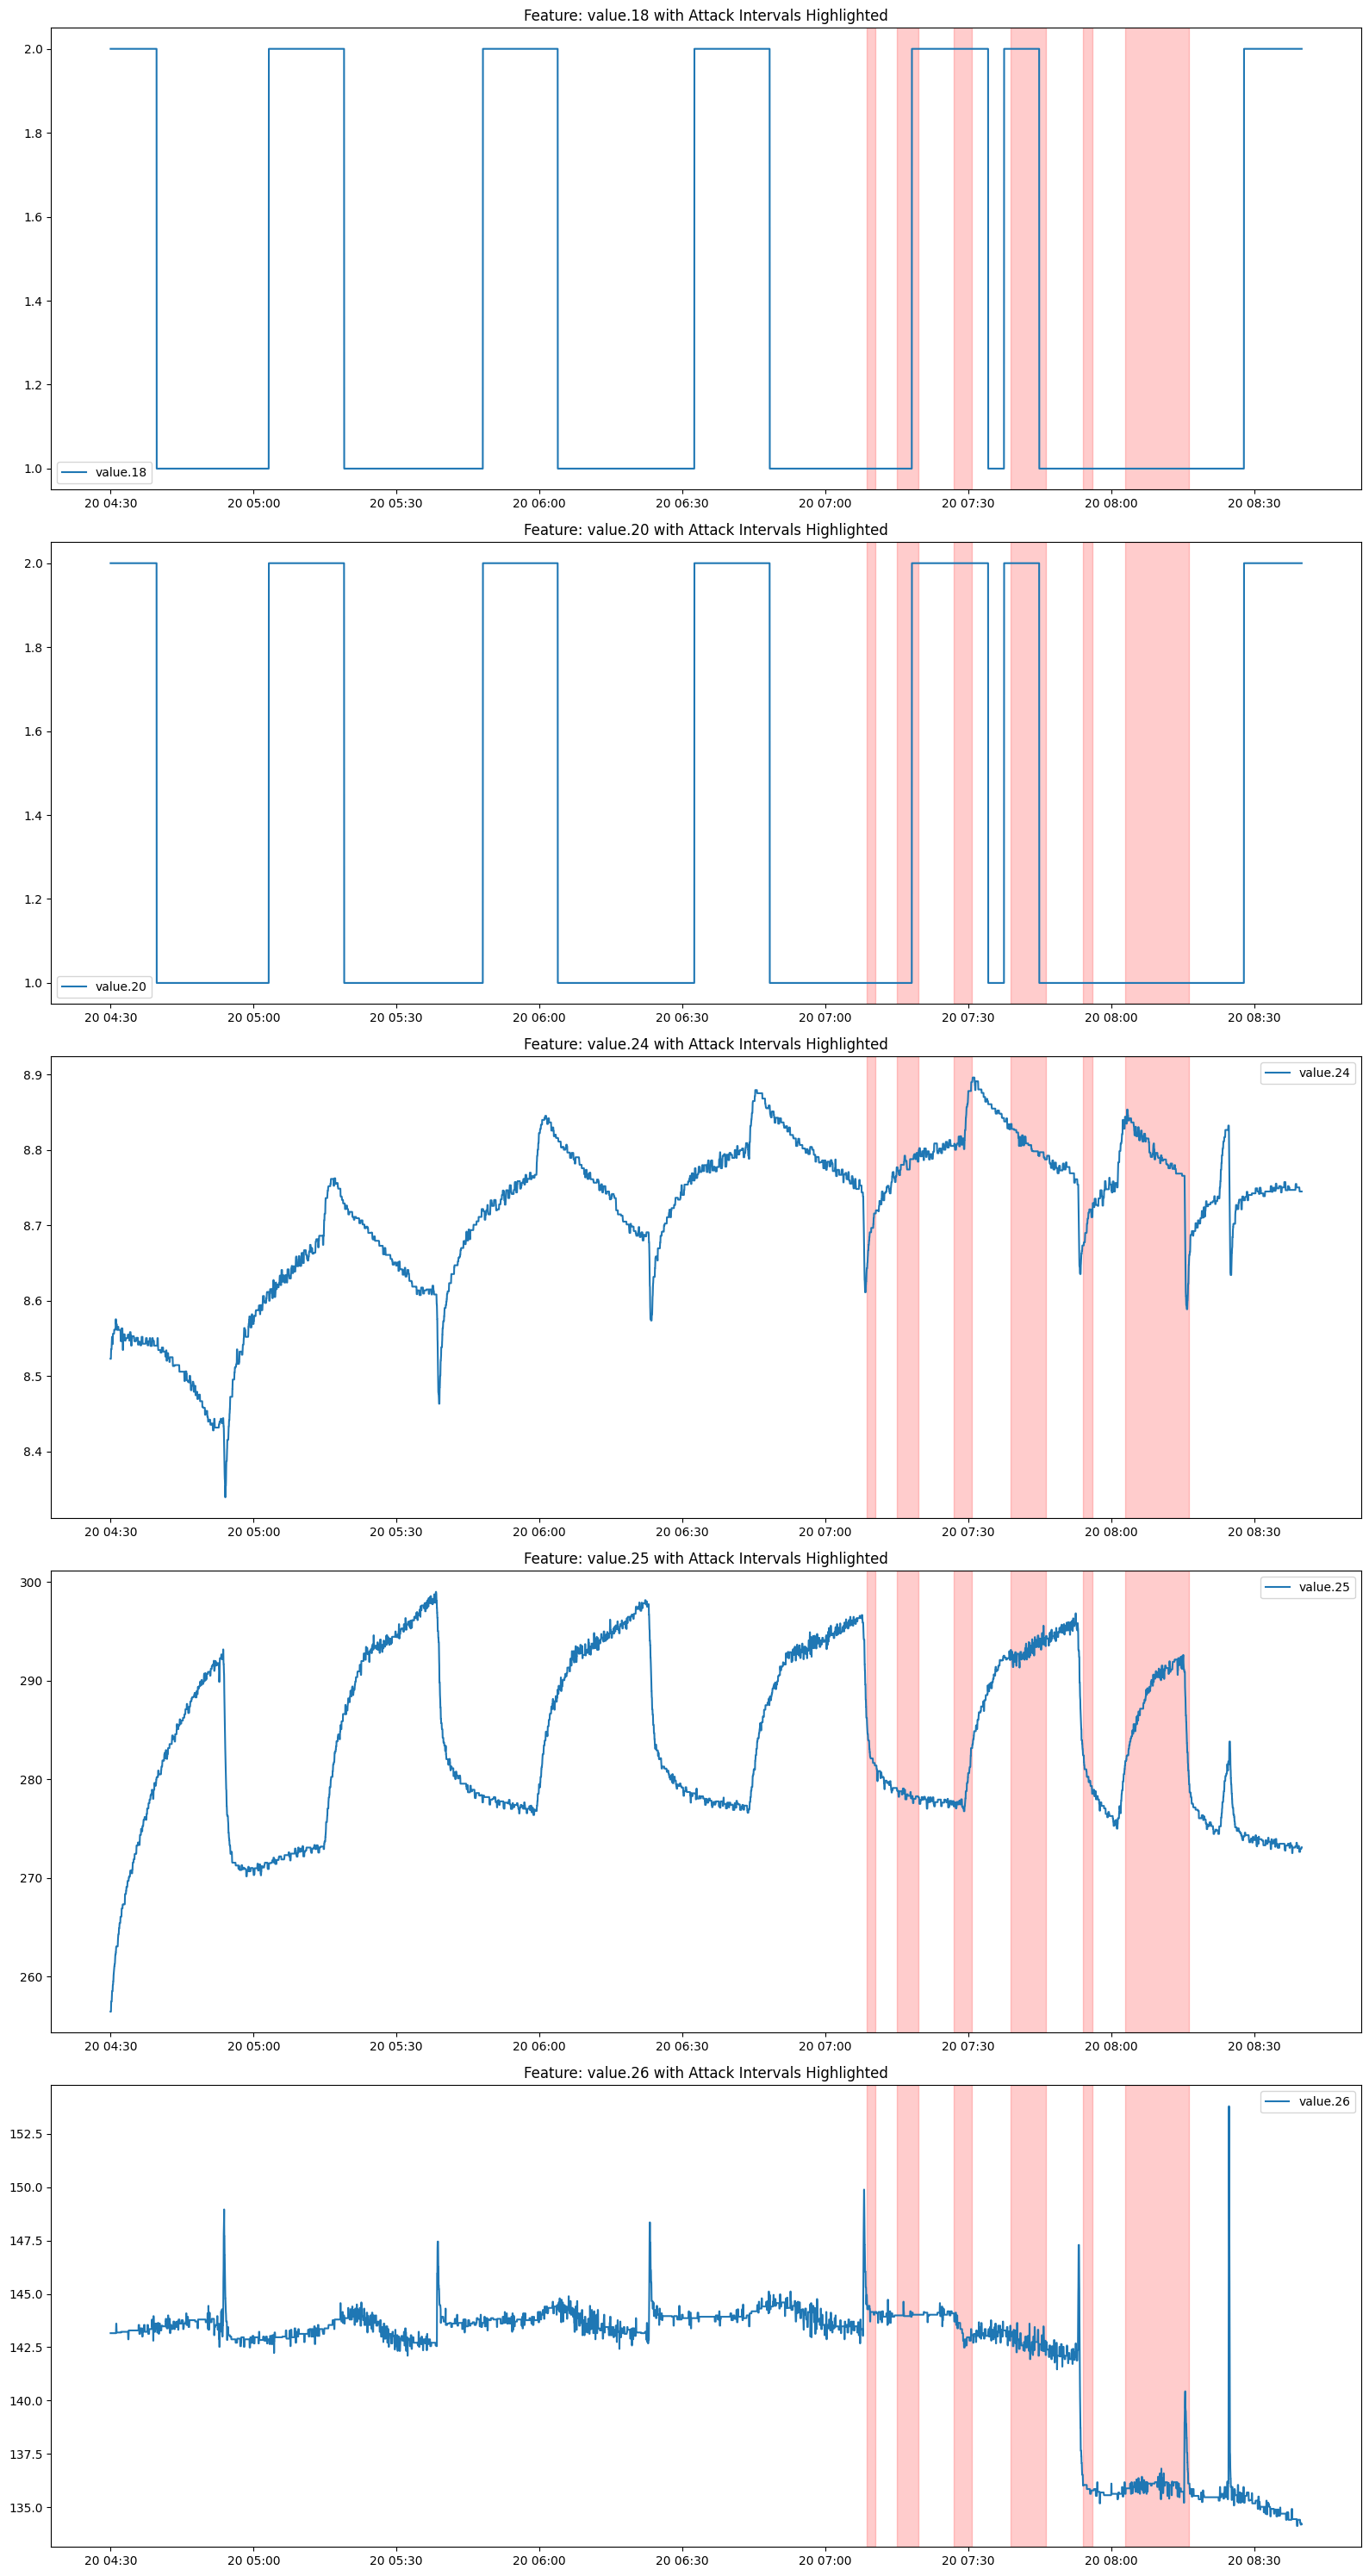

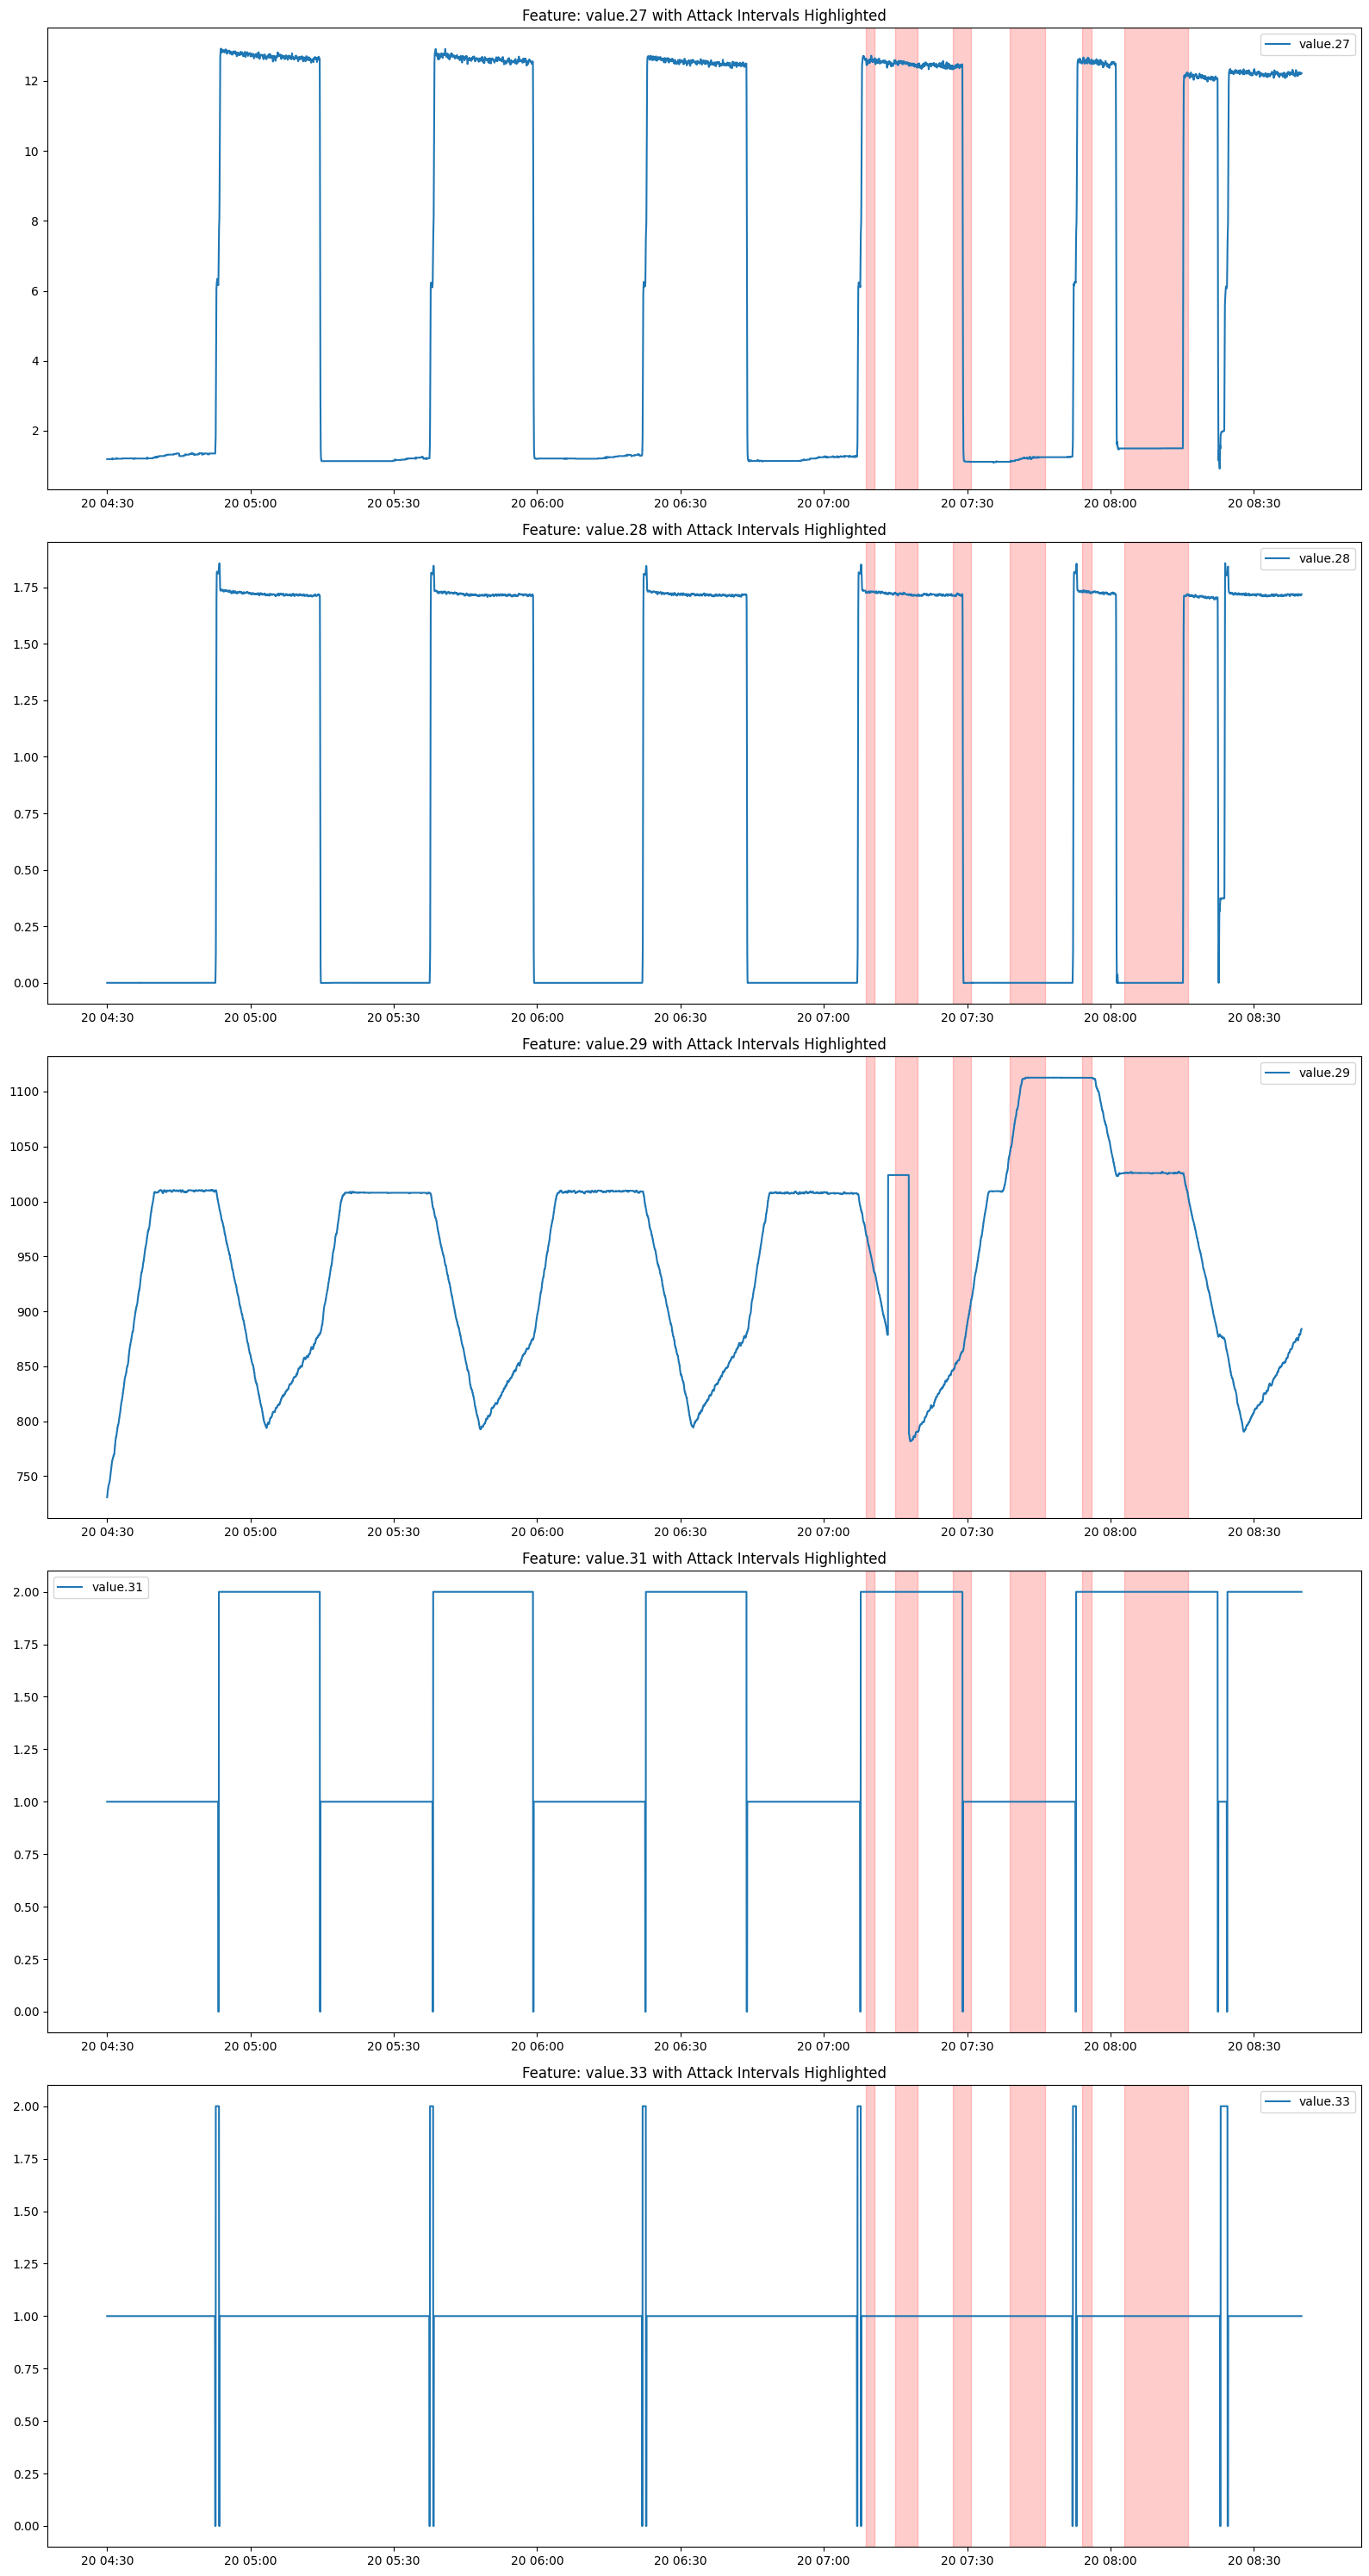

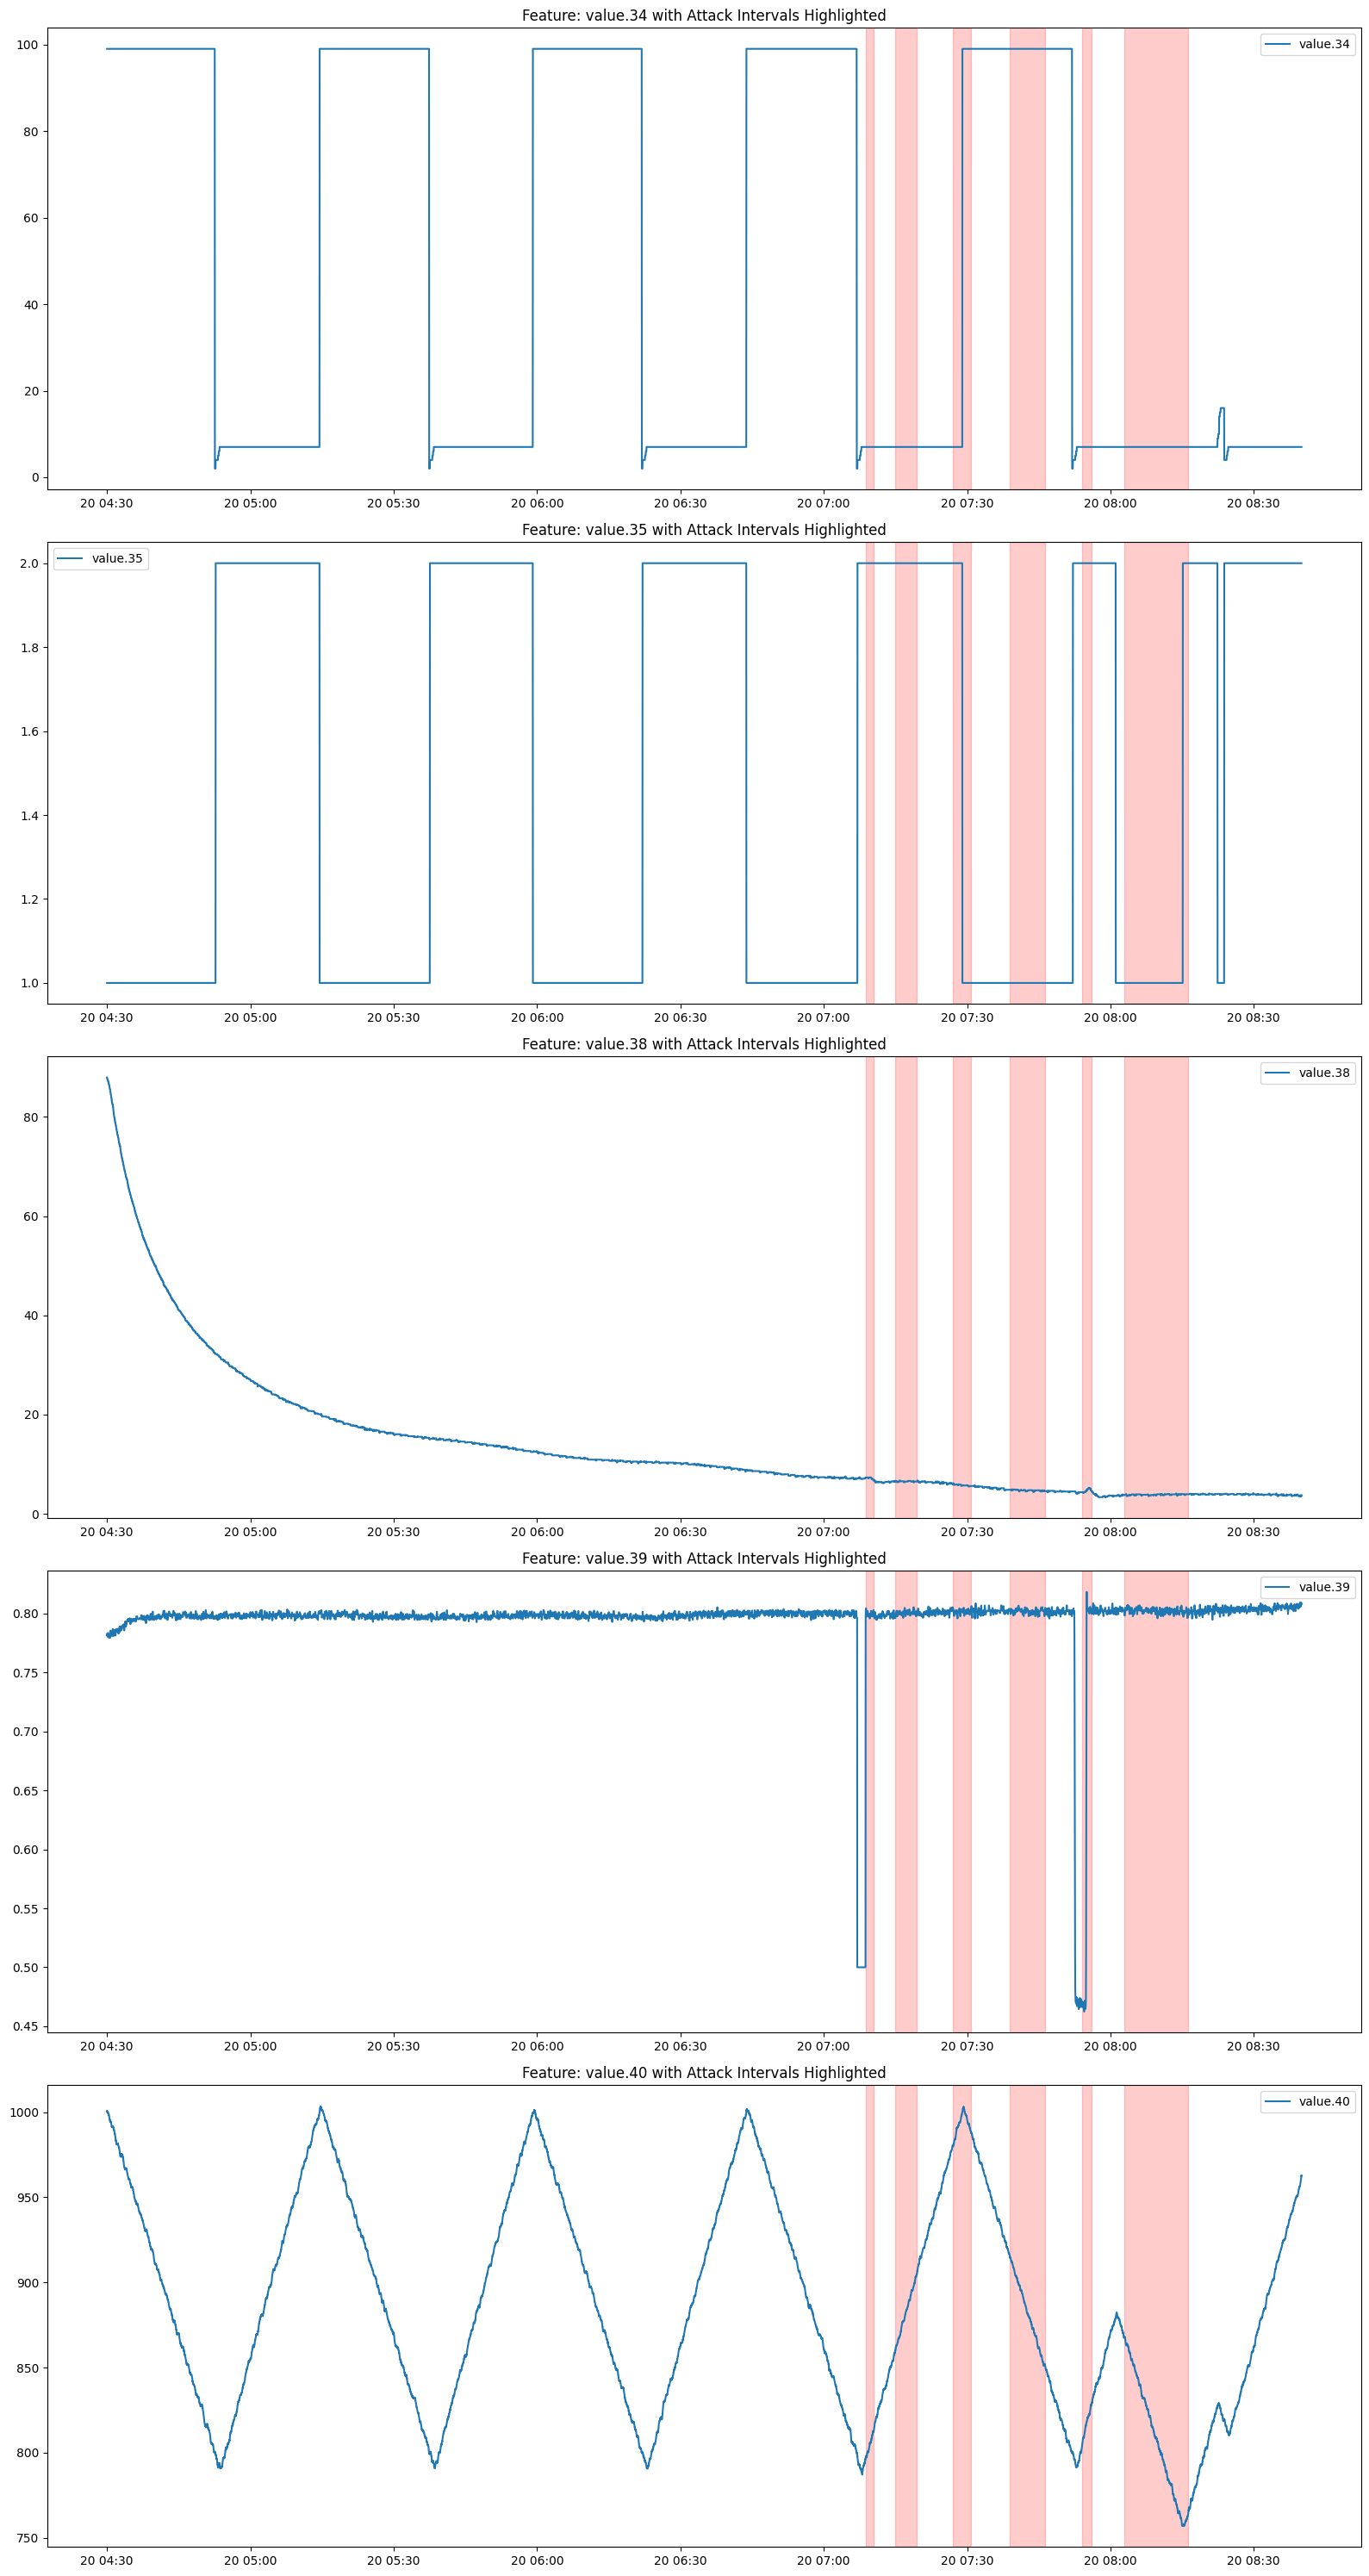

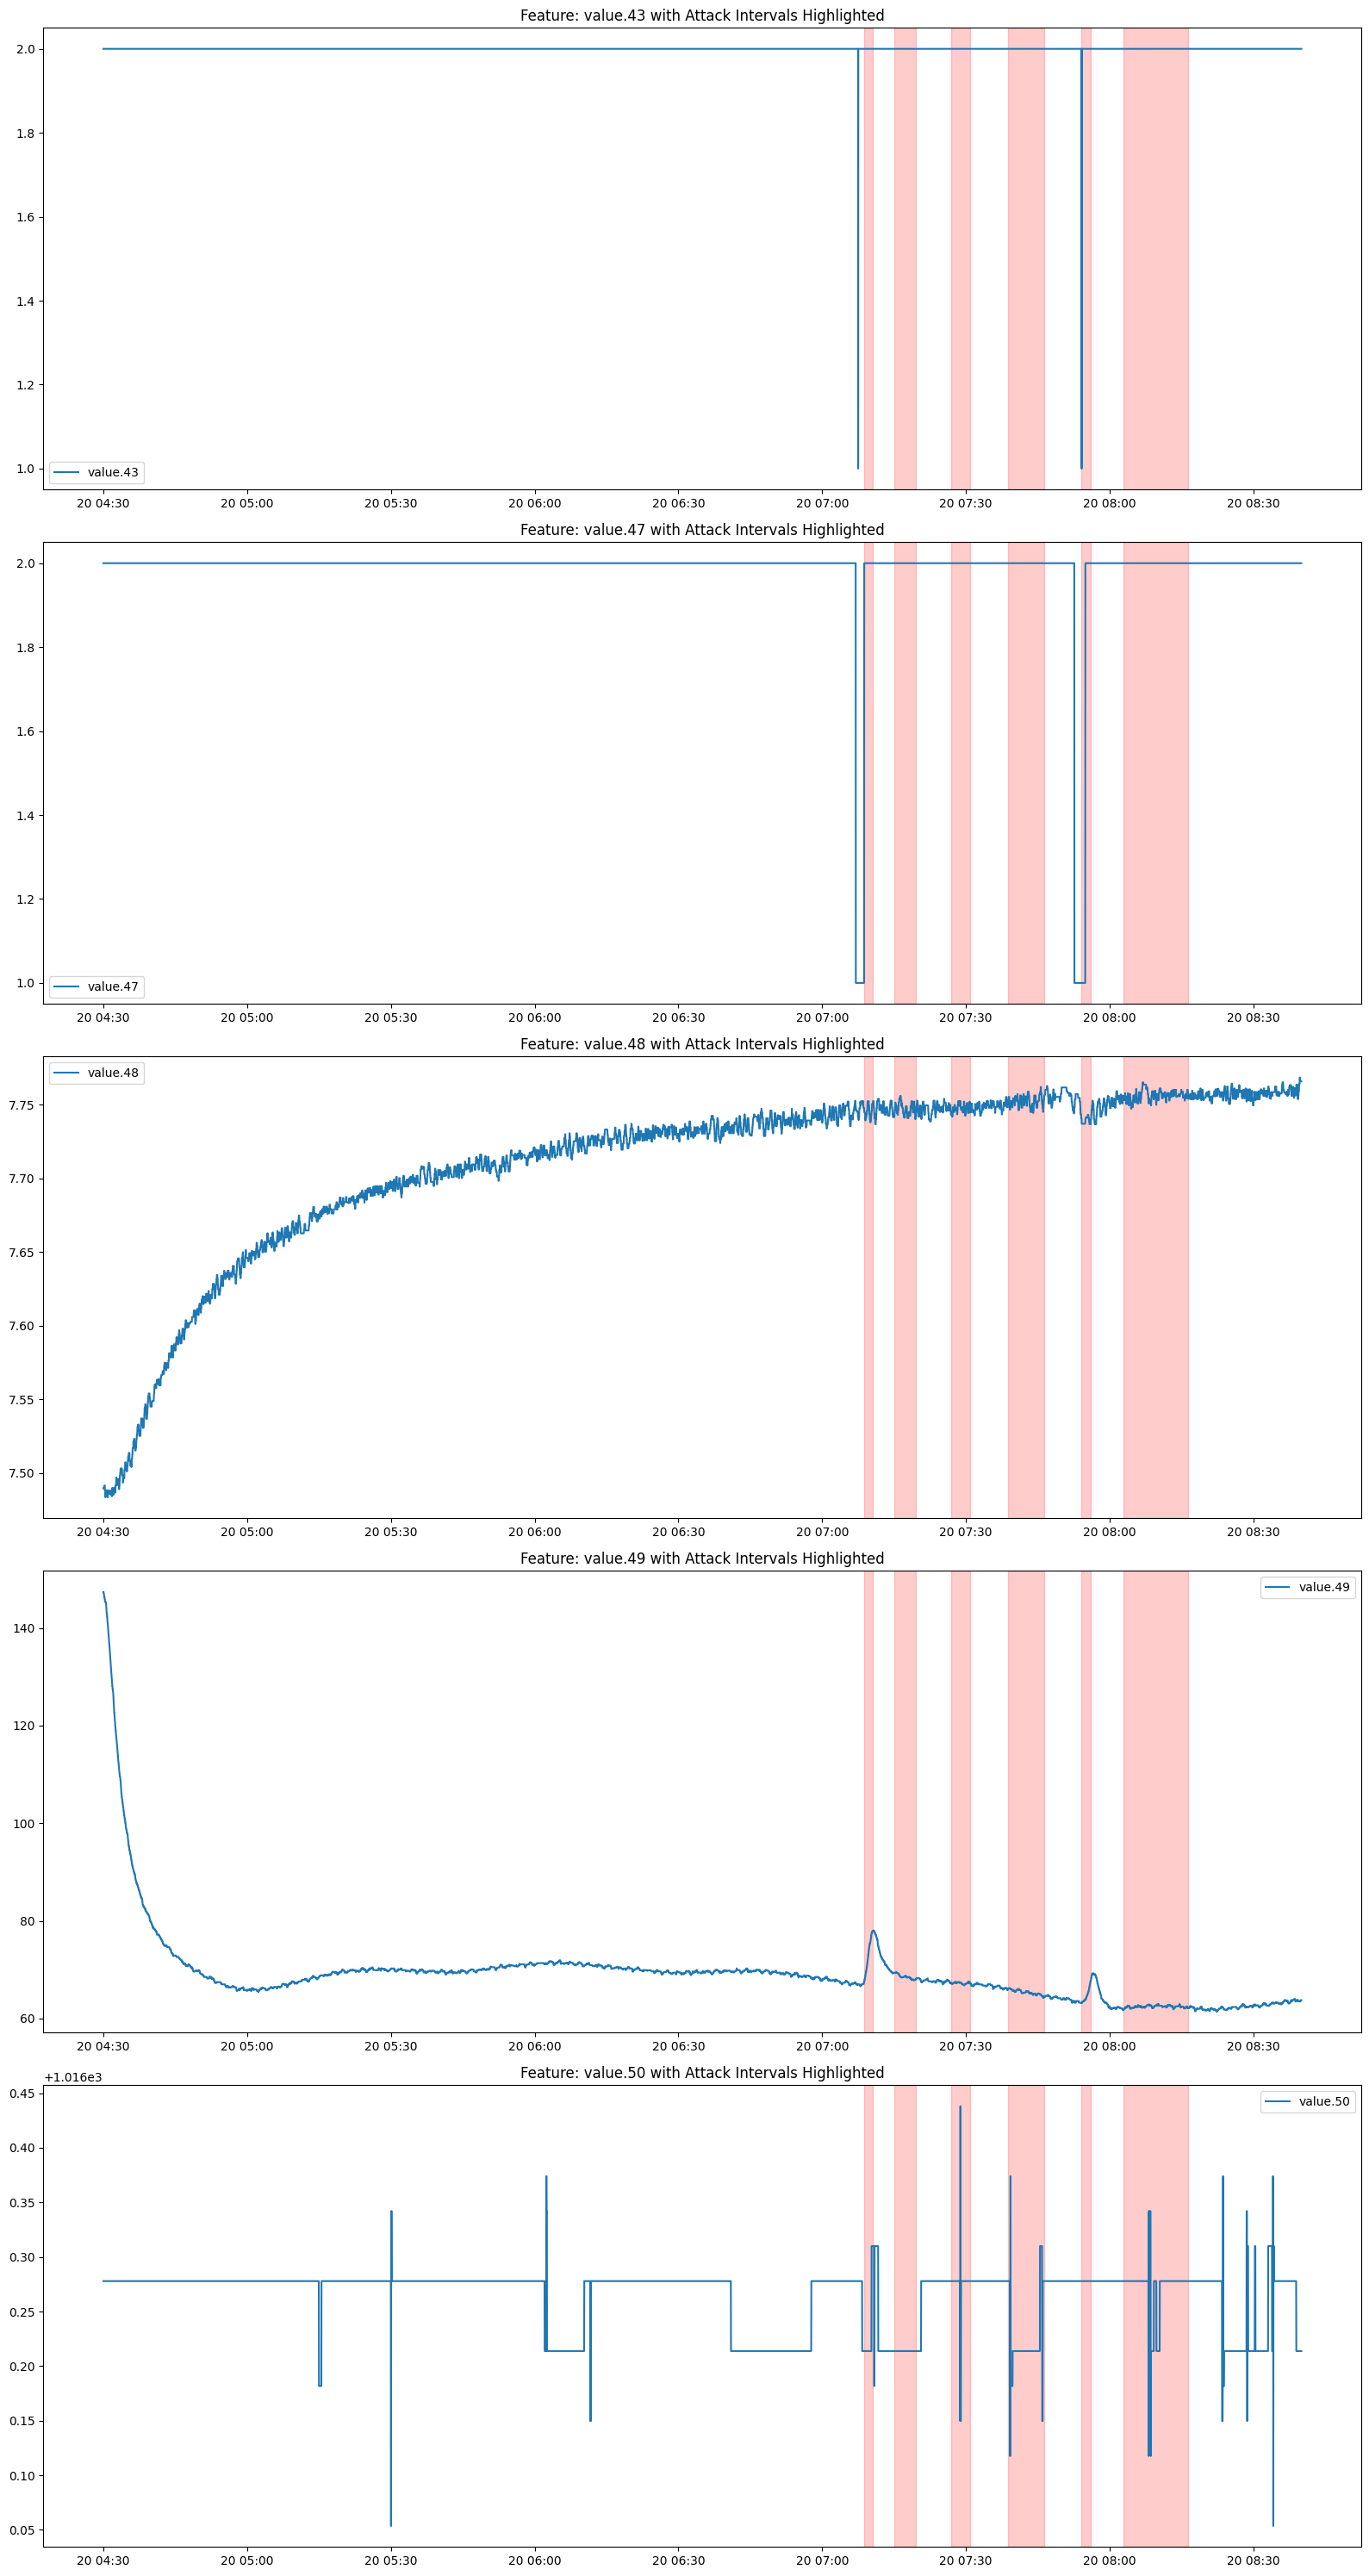

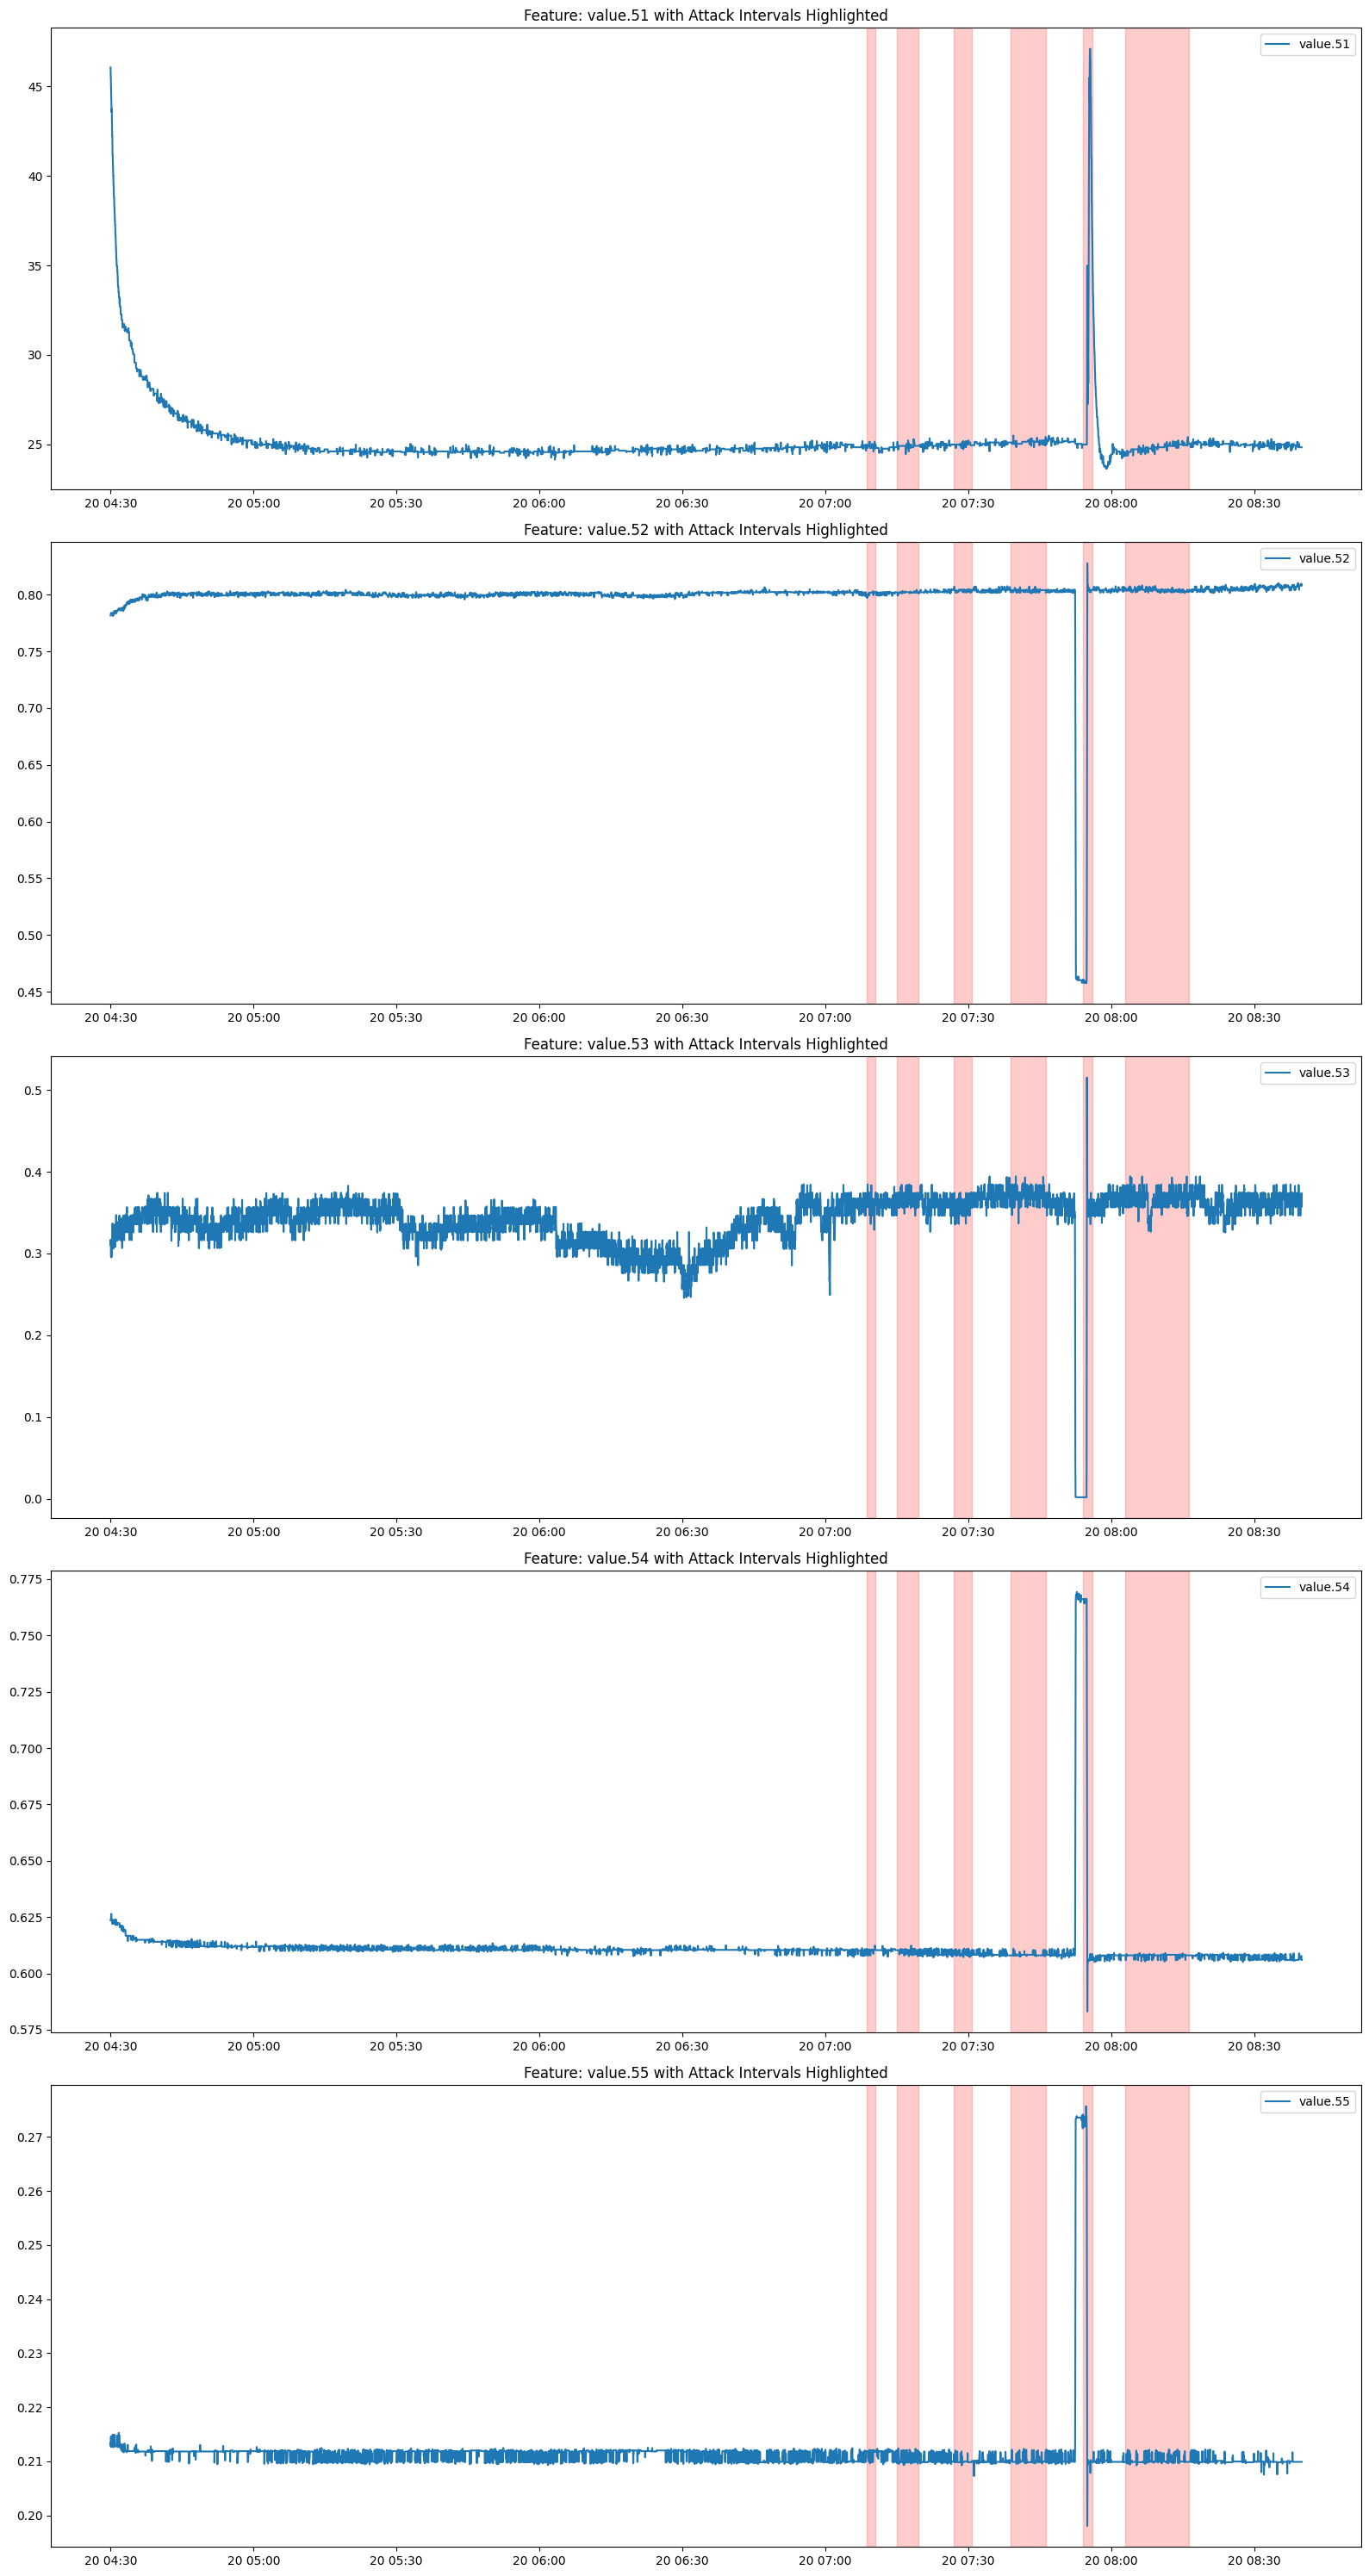

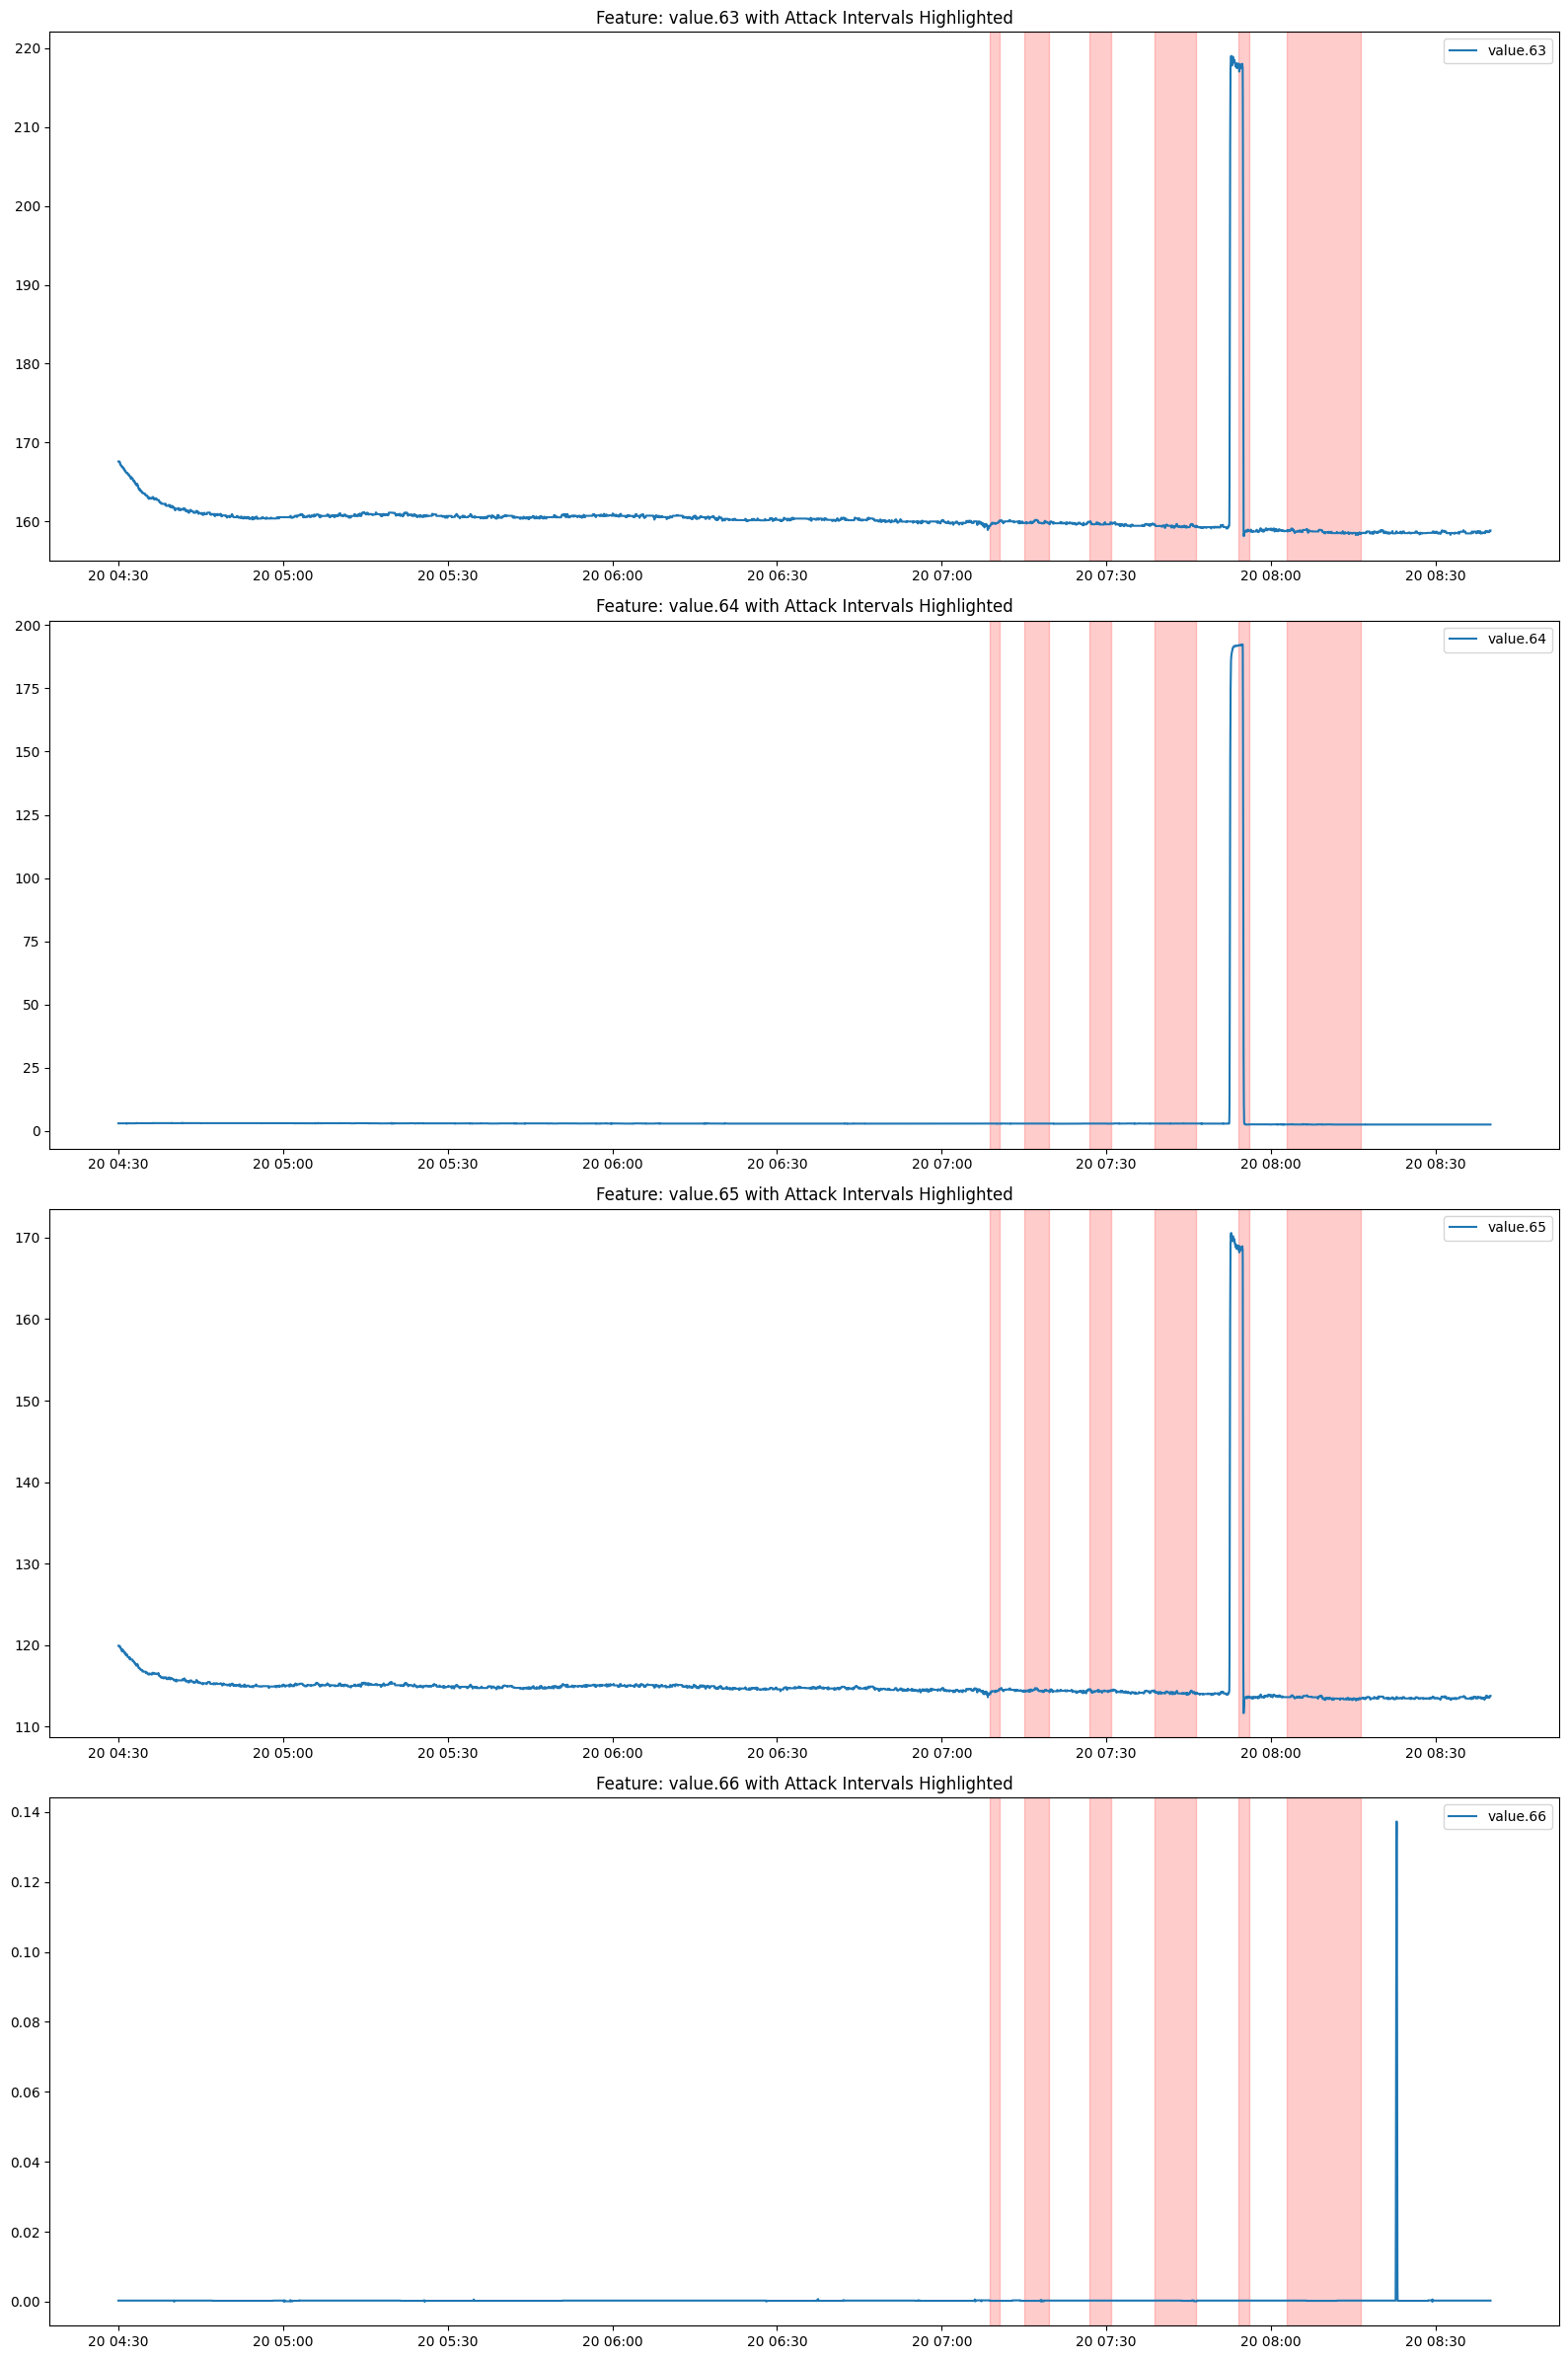

In [ ]:
# Plot features in chunks of 5
chunk_size = 5
for i in range(0, len(features_final), chunk_size):
    features_chunk = features_final[i:i + chunk_size]
    plt.figure(figsize=(16, 6 * len(features_chunk))) # Adjust figure size based on number of features in chunk

    for j, feature_to_plot in enumerate(features_chunk):
        plt.subplot(len(features_chunk), 1, j + 1) # Create subplot for each feature
        plt.plot(df_swat['timestamp'], df_swat[feature_to_plot], label=feature_to_plot)

        # Shade attack region
        for start, end in attack_intervals:
            plt.axvspan(start, end, color='red', alpha=0.2)
        plt.legend()
        plt.title(f"Feature: {feature_to_plot} with Attack Intervals Highlighted")

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()

##Model Training

In [ ]:
#GRU
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'
tf.config.experimental.enable_op_determinism()

GRU_model = keras.Sequential([
    layers.GRU(units = 8, return_sequences=False,
    input_shape=(train_windows.shape[1], train_windows.shape[2])),
    layers.Dropout(0.5),
    layers.RepeatVector(train_windows.shape[1]),

    layers.GRU(units = 8, return_sequences=True),
    layers.Dropout(0.5),
    layers.TimeDistributed(layers.Dense(train_windows.shape[2]))

])

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
GRU_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

GRU_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8)              │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 30, 8)          │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 39)         │           351 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,959 (7.65 KB)

 Trainable params: 1,959 (7.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the GRU
X_train = train_windows
X_val = validation_windows

GRU_history = GRU_model.fit(
    X_train,X_train,
    validation_data = (X_val, X_val),
    epochs = 30,
    batch_size = 32,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)
    ],
    shuffle = True
)

Epoch 1/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.4201 - mae: 0.5275 - val_loss: 0.4811 - val_mae: 0.4988
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.3161 - mae: 0.4511 - val_loss: 0.4024 - val_mae: 0.4387
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.2504 - mae: 0.3957 - val_loss: 0.3388 - val_mae: 0.3826
Epoch 4/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.2020 - mae: 0.3518 - val_loss: 0.2997 - val_mae: 0.3440
Epoch 5/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.1694 - mae: 0.3198 - val_loss: 0.2770 - val_mae: 0.3195
Epoch 6/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.1480 - mae: 0.2975 - val_loss: 0.2602 - val_mae: 0.2991
Epoch 7/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.1323 - mae: 0.2801 - val_loss: 0.2489 - val_mae: 0.2849
Epoch 8/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.1213 - mae: 0.2674 - val_loss: 0.2392 - val_mae: 0.2719
Epoch 9/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 9s 

In [ ]:
# Run GRU predictions
GRU_X_val_pred = GRU_model.predict(X_val)

# X_val is your validation_windows tensor
X_val_np = X_val.numpy()

GRU_y_val_np = y_val_window_labels.numpy()

# Compute reconstruction error per sequence
GRU_reconstruction_error = np.mean(np.square(GRU_X_val_pred - X_val_np), axis=(1, 2))

GRU_BEST_THRESHOLD = 0.20

GRU_y_pred_labels = (GRU_reconstruction_error > GRU_BEST_THRESHOLD).astype(int)
GRU_prec, GRU_rec, GRU_f1, _ = precision_recall_fscore_support(
    GRU_y_val_np , GRU_y_pred_labels, average='binary', zero_division=0
)

# Calculate mean and std for reconstruction errors for tuning.
GRU_mean_error = np.mean(GRU_reconstruction_error)
GRU_std_error = np.std(GRU_reconstruction_error)
GRU_training_error = GRU_history.history['loss'][-1]
GRU_validation_error = GRU_history.history['val_loss'][-1]

print(f"GRU Metrics: Mean Error = {GRU_mean_error:.4f}, Std Dev = {GRU_std_error:.4f}, Training Error = {GRU_training_error:.4f}, Validation Error = {GRU_validation_error:.4f}")
print(f"Precision: {GRU_prec:.3f} | Recall: {GRU_rec:.3f} | F1: {GRU_f1:.3f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
GRU Metrics: Mean Error = 0.1622, Std Dev = 0.3112, Training Error = 0.0463, Validation Error = 0.1622
Precision: 0.991 | Recall: 0.364 | F1: 0.532


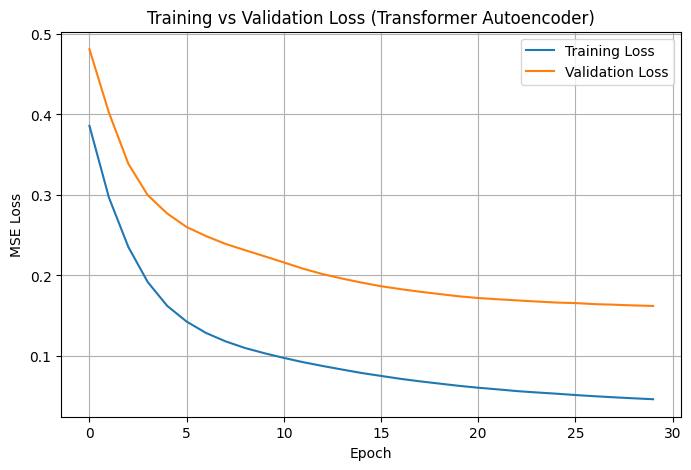

In [ ]:
loss_key = 'loss'
val_loss_key = 'val_loss'

plt.figure(figsize=(8,5))
plt.plot(GRU_history.history[loss_key], label='Training Loss')
plt.plot(GRU_history.history[val_loss_key], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (Transformer Autoencoder)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# LSTM
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'
tf.config.experimental.enable_op_determinism()

# Create the model with encoder and decoder
LSTM_model = keras.Sequential([
    # Encoder
    layers.LSTM(8,
                return_sequences = False,
                input_shape=(train_windows.shape[1], train_windows.shape[2]),
                kernel_regularizer=l2(1e-3)
                ),
    layers.Dropout(0.5),
    layers.RepeatVector(train_windows.shape[1]),

    #Decoder
    layers.LSTM(8, return_sequences=True,
    kernel_regularizer=l2(1e-3)),
    layers.Dropout(0.5),
    layers.TimeDistributed(layers.Dense(train_windows.shape[2], activation = 'linear'))
])

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
LSTM_model.compile(
    optimizer=optimizer, loss='mse', metrics=['mae']
)
LSTM_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8)              │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 30, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 8)          │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 39)         │           351 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431 (9.50 KB)

 Trainable params: 2,431 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the LSTM
X_train = train_windows
X_val = validation_windows

LSTM_history = LSTM_model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    shuffle=True
)

Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.4264 - mae: 0.4993 - val_loss: 0.5070 - val_mae: 0.4968
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.3378 - mae: 0.4393 - val_loss: 0.3950 - val_mae: 0.4145
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.2571 - mae: 0.3744 - val_loss: 0.3251 - val_mae: 0.3501
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.2054 - mae: 0.3288 - val_loss: 0.2866 - val_mae: 0.3088
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.1736 - mae: 0.2998 - val_loss: 0.2652 - val_mae: 0.2873
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.1543 - mae: 0.2822 - val_loss: 0.2523 - val_mae: 0.2760
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 0.1404 - mae: 0.2701 - val_loss: 0.2438 - val_mae: 0.2685
Epoch 8/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.1306 - mae: 0.2616 - val_loss: 0.2377 - val_mae: 0.2630
Epoch 9/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 10s

In [ ]:
# Run LSTM predictions
LSTM_X_val_pred = LSTM_model.predict(X_val)

# X_val is your validation_windows tensor
X_val_np = X_val.numpy()

LSTM_y_val_np = y_val_window_labels.numpy()

# Compute reconstruction error per sequence
LSTM_reconstruction_error = np.mean(np.square(LSTM_X_val_pred - X_val_np), axis=(1, 2))

LSTM_BEST_THRESHOLD = 0.15

LSTM_y_pred_labels = (LSTM_reconstruction_error > LSTM_BEST_THRESHOLD).astype(int)
LSTM_prec, LSTM_rec, LSTM_f1, _ = precision_recall_fscore_support(
    LSTM_y_val_np , LSTM_y_pred_labels, average='binary', zero_division=0
)

# Calculate mean and std for reconstruction errors for tuning.
LSTM_mean_error = np.mean(LSTM_reconstruction_error)
LSTM_std_error = np.std(LSTM_reconstruction_error)
LSTM_training_error = LSTM_history.history['loss'][-1]
LSTM_validation_error = LSTM_history.history['val_loss'][-1]

print(f"LSTM Metrics: Mean Error = {LSTM_mean_error:.4f}, Std Dev = {LSTM_std_error:.4f}, Training Error = {LSTM_training_error:.4f}, Validation Error = {LSTM_validation_error:.4f}")
print(f"Precision: {LSTM_prec:.3f} | Recall: {LSTM_rec:.3f} | F1: {LSTM_f1:.3f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
LSTM Metrics: Mean Error = 0.1519, Std Dev = 0.3001, Training Error = 0.0360, Validation Error = 0.1532
Precision: 0.947 | Recall: 0.364 | F1: 0.525


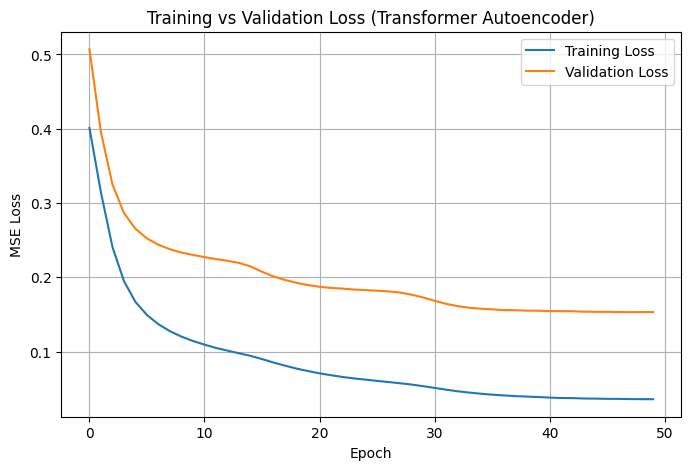

In [ ]:
loss_key = 'loss'
val_loss_key = 'val_loss'

plt.figure(figsize=(8,5))
plt.plot(LSTM_history.history[loss_key], label='Training Loss')
plt.plot(LSTM_history.history[val_loss_key], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (Transformer Autoencoder)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_losses = []
val_losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Positional Encoding ----------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :].unsqueeze(0).to(x.device)


# ---------- Transformer Autoencoder ----------
class TransformerAutoencoder(nn.Module):
    def __init__(
        self,
        n_features,
        d_model=16,
        nhead=2,
        num_layers=1,
        dim_feedforward=16,
        dropout=0.5,
        seq_len=10,
        input_dropout=0.3,
        noise_std=0.05,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.noise_std = noise_std

        self.input_norm = nn.LayerNorm(n_features)
        self.input_dropout = nn.Dropout(input_dropout)
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=seq_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, n_features)

    def forward(self, x):
        # Add Gaussian noise only during training
        if self.training and self.noise_std > 0:
            noise = torch.randn_like(x) * self.noise_std
            x = x + noise

        x = self.input_norm(x)
        x = self.input_dropout(x)
        x = self.input_proj(x)
        x = self.pos_enc(x)
        enc = self.encoder(x)
        enc = self.ln(enc)
        out = self.output_proj(enc)
        return out


# ---------- Dataloaders ----------
def make_dataloader(windows_tensor, batch_size=4, shuffle=True):
    ds = TensorDataset(windows_tensor, windows_tensor)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)


# ---------- Hyperparams ----------
seq_len = train_windows.shape[1]
n_features = train_windows.shape[2]
batch_size = 4
lr = 1e-5
weight_decay = 1e-3
epochs = 30
patience = 3

train_loader = make_dataloader(train_windows, batch_size=batch_size, shuffle=True)
val_loader = make_dataloader(validation_windows, batch_size=batch_size, shuffle=False)
test_loader = make_dataloader(test_windows, batch_size=batch_size, shuffle=False)

# ---------- Init model ----------
model = TransformerAutoencoder(
    n_features=n_features,
    d_model=8,
    nhead=1,
    num_layers=1,
    dim_feedforward=16,
    dropout=0.5,
    seq_len=seq_len,
    input_dropout=0.3,
    noise_std=0.05
).to(device)

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


# ---------- Training / Validation ----------
def train_one_epoch(model, loader, optimizer, device, clip_grad=1.0):
    model.train()
    running_loss, count = 0.0, 0
    for x_in, x_target in loader:
        x_in, x_target = x_in.to(device), x_target.to(device)
        optimizer.zero_grad()
        recon = model(x_in)
        loss = criterion(recon, x_target).mean()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        running_loss += loss.item() * x_in.size(0)
        count += x_in.size(0)
    return running_loss / count


def validate(model, loader, device):
    model.eval()
    running_loss, count = 0.0, 0
    with torch.no_grad():
        for x_in, x_target in loader:
            x_in, x_target = x_in.to(device), x_target.to(device)
            recon = model(x_in)
            loss = criterion(recon, x_target).mean()
            running_loss += loss.item() * x_in.size(0)
            count += x_in.size(0)
    return running_loss / count


# ---------- Training Loop ----------
best_val = float('inf')
epochs_no_improve = 0
save_path = "best_transformer_autoencoder.pth"

for epoch in range(1, epochs + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)
    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:03d} | Train: {tr_loss:.6f} | Val: {val_loss:.6f}")

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print("  -> saved best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | Train: 0.704432 | Val: 0.656448
  -> saved best model
Epoch 002 | Train: 0.488553 | Val: 0.487956
  -> saved best model
Epoch 003 | Train: 0.329739 | Val: 0.372226
  -> saved best model
Epoch 004 | Train: 0.219512 | Val: 0.292992
  -> saved best model
Epoch 005 | Train: 0.146433 | Val: 0.242574
  -> saved best model
Epoch 006 | Train: 0.104166 | Val: 0.216401
  -> saved best model
Epoch 007 | Train: 0.083713 | Val: 0.205769
  -> saved best model
Epoch 008 | Train: 0.074664 | Val: 0.201581
  -> saved best model
Epoch 009 | Train: 0.069869 | Val: 0.198203
  -> saved best model
Epoch 010 | Train: 0.066065 | Val: 0.194994
  -> saved best model
Epoch 011 | Train: 0.062467 | Val: 0.191409
  -> saved best model
Epoch 012 | Train: 0.058962 | Val: 0.187654
  -> saved best model
Epoch 013 | Train: 0.055490 | Val: 0.183556
  -> saved best model
Epoch 014 | Train: 0.052037 | Val: 0.179798
  -> saved best model
Epoch 015 | Train: 0.048660 | Val: 0.176089
  -> saved best model
Epoch 016 

Validation Reconstruction AUC: 0.8562

--- Best Validation Metrics ---
Best Threshold: 1.770430e-02
Precision: 0.747 | Recall: 0.834 | F1: 0.788


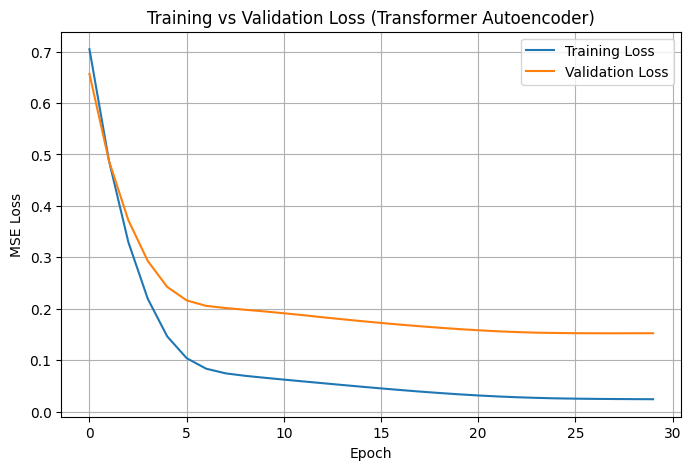

In [ ]:
BATCH_SIZE = 64 # Or whatever batch size you prefer for evaluation

train_dataset = TensorDataset(train_windows, y_train_window_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = TensorDataset(validation_windows, y_val_window_labels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --- 2. Compute Reconstruction Errors ---
# (This function is the same as yours, just included for completeness)
def compute_reconstruction_errors(model, loader, device):
    model.eval()
    errors = []
    with torch.no_grad():
        # The loader now correctly yields (window_data, window_label)
        for x_in, _ in loader:
            x_in = x_in.to(device)
            recon = model(x_in)
            mse_per_elem = (recon - x_in).square().mean(dim=(1, 2))
            errors.append(mse_per_elem.detach().cpu().numpy())
    return np.concatenate(errors, axis=0)


# --- 3. Evaluate on Validation Set (with CORRECTED labels) ---

# Load best model
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

# Compute reconstruction errors (this part is now correct
# because the loaders are correct)
val_errors = compute_reconstruction_errors(model, val_loader, device)
train_errors = compute_reconstruction_errors(model, train_loader, device)

# Use the NEW windowed labels, not the old tensor
y_val_np = y_val_window_labels.numpy() if isinstance(y_val_window_labels, torch.Tensor) else np.array(y_val_window_labels)

# --- 4. Compute validation metrics ---
# (The rest of this logic is now correct because y_val_np is correct)
try:
    auc = roc_auc_score(y_val_np, val_errors)
    print(f"Validation Reconstruction AUC: {auc:.4f}")
except Exception as e:
    # This check is good, in case y_val_np has no anomalies
    print("Could not compute AUC (check label shapes and content):", e)

# Find the best threshold to maximize F1
# (This is a much better way to find a threshold than a fixed percentile)
best_f1 = -1
best_threshold = 0
for threshold in np.percentile(val_errors, np.arange(0, 100, 1)): # Test 100 thresholds
    y_pred_val = (val_errors >= threshold).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_val_np, y_pred_val, average='binary', zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_prec = prec
        best_rec = rec

print("\n--- Best Validation Metrics ---")
print(f"Best Threshold: {best_threshold:.6e}")
print(f"Precision: {best_prec:.3f} | Recall: {best_rec:.3f} | F1: {best_f1:.3f}")

# --- 5. Visualization ---
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (Transformer Autoencoder)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data = [["GRU", 0.991, 0.364, 0.532, 0.04632, 0.1622],
 ["LSTM", 0.947 ,0.364, 0.525, 0.0360, 0.1532],
 ["Transformer",0.747 , 0.843 ,0.788 , 0.0243, 0.1526 ]]

headers = ["Model","Precision", "Recall", "F1", "Training Error", "Validation Error"]

print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

╒═════════════╤═════════════╤══════════╤═══════╤══════════════════╤════════════════════╕
│ Model       │   Precision │   Recall │    F1 │   Training Error │   Validation Error │
╞═════════════╪═════════════╪══════════╪═══════╪══════════════════╪════════════════════╡
│ GRU         │       0.991 │    0.364 │ 0.532 │          0.04632 │             0.1622 │
├─────────────┼─────────────┼──────────┼───────┼──────────────────┼────────────────────┤
│ LSTM        │       0.947 │    0.364 │ 0.525 │          0.036   │             0.1532 │
├─────────────┼─────────────┼──────────┼───────┼──────────────────┼────────────────────┤
│ Transformer │       0.747 │    0.843 │ 0.788 │          0.0243  │             0.1526 │
╘═════════════╧═════════════╧══════════╧═══════╧══════════════════╧════════════════════╛


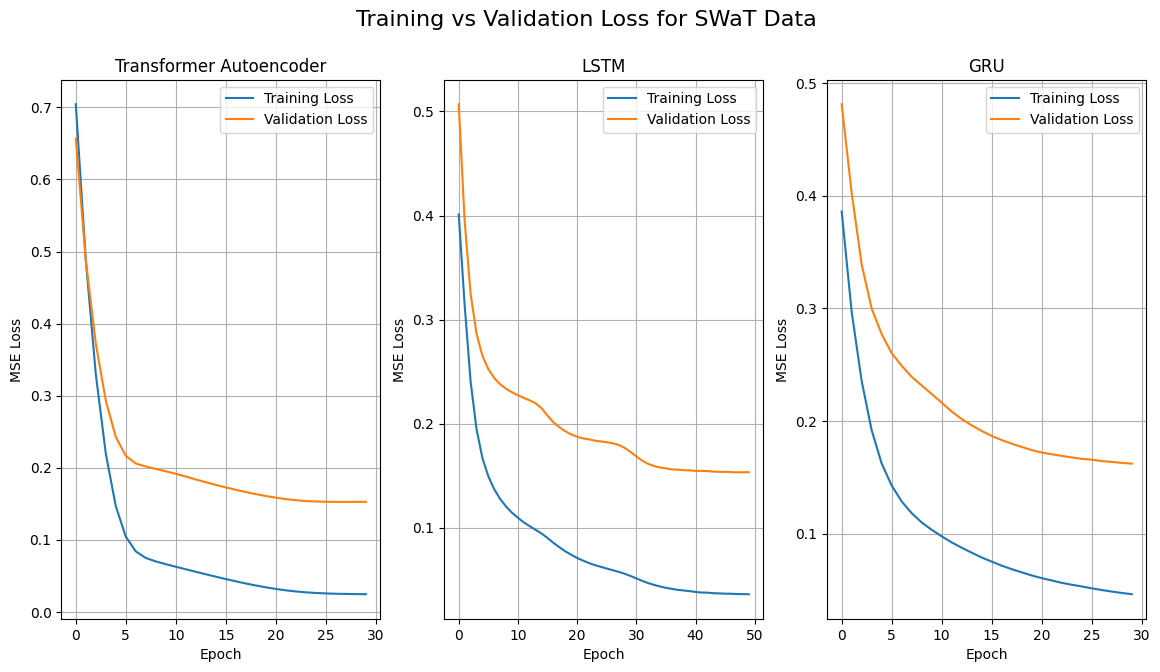

In [ ]:
loss_key = 'loss'
val_loss_key = 'val_loss'
fig, axes = plt.subplots(1, 3, figsize=(14, 7), sharey=False)
fig.suptitle('Training vs Validation Loss for SWaT Data', fontsize=16)

axes[0].plot(train_losses, label="Training Loss")
axes[0].plot(val_losses, label="Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].set_title("Transformer Autoencoder")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(LSTM_history.history[loss_key], label='Training Loss')
axes[1].plot(LSTM_history.history[val_loss_key], label='Validation Loss')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MSE Loss")
axes[1].set_title("LSTM")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(GRU_history.history[loss_key], label='Training Loss')
axes[2].plot(GRU_history.history[val_loss_key], label='Validation Loss')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("MSE Loss")
axes[2].set_title("GRU")
axes[2].legend()
axes[2].grid(True)

plt.show()

In [ ]:
# Fit GRU to the test data

GRU_test_pred = GRU_model.predict(test_windows)

test_windows_np = test_windows.numpy()

# Make sure to use the new windowed labels
GRU_y_test_np = y_test_window_labels.numpy() # Use the new windowed labels

GRU_test_reconstruction_error = np.mean(np.square(GRU_test_pred - test_windows_np), axis=(1, 2))

threshold = GRU_BEST_THRESHOLD
GRU_test_pred_labels = (GRU_test_reconstruction_error > threshold).astype(int)

# This comparison is now correctly aligned
GRU_test_prec, GRU_test_rec, GRU_test_f1, _ = precision_recall_fscore_support(
    GRU_y_test_np,
    GRU_test_pred_labels,
    average='binary',
    zero_division=0
)

# Calculate mean and std for reconsturction errors for tuning.
GRU_test_mean_error = np.mean(GRU_test_reconstruction_error)
GRU_test_std_error = np.std(GRU_test_reconstruction_error)
print(f"GRU Metrics: Mean Error = {GRU_test_mean_error:.4f}, Std Dev = {GRU_test_std_error:.4f}")
print(f"Precision: {GRU_test_prec:.3f} | Recall: {GRU_test_rec:.3f} | F1: {GRU_test_f1:.3f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
GRU Metrics: Mean Error = 231.8701, Std Dev = 1173.0426
Precision: 0.354 | Recall: 1.000 | F1: 0.523


In [ ]:
# Fit LSTM to the test data

LSTM_test_pred = LSTM_model.predict(test_windows)

test_windows_np = test_windows.numpy()

# Make sure to use the new windowed labels
LSTM_y_test_np = y_test_window_labels.numpy() # Use the new windowed labels

# ... (your predict and error calculation code is the same) ...
LSTM_test_reconstruction_error = np.mean(np.square(LSTM_test_pred - test_windows_np), axis=(1, 2))

threshold = LSTM_BEST_THRESHOLD
LSTM_test_pred_labels = (LSTM_test_reconstruction_error > threshold).astype(int)

# This comparison is now correctly aligned
LSTM_test_prec, LSTM_test_rec, LSTM_test_f1, _ = precision_recall_fscore_support(
    LSTM_y_test_np,
    LSTM_test_pred_labels,
    average='binary',
    zero_division=0
)

# Calculate mean and std for reconsturction errors for tuning.
LSTM_test_mean_error = np.mean(LSTM_test_reconstruction_error)
LSTM_test_std_error = np.std(LSTM_test_reconstruction_error)
print(f"LSTM Metrics: Mean Error = {LSTM_test_mean_error:.4f}, Std Dev = {LSTM_test_std_error:.4f}")
print(f"Precision: {LSTM_test_prec:.3f} | Recall: {LSTM_test_rec:.3f} | F1: {LSTM_test_f1:.3f}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
LSTM Metrics: Mean Error = 231.8407, Std Dev = 1172.9684
Precision: 0.354 | Recall: 1.000 | F1: 0.523


In [ ]:
BATCH_SIZE = 64 # Or whatever batch size you prefer

train_dataset = TensorDataset(train_windows, y_train_window_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = TensorDataset(validation_windows, y_val_window_labels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(test_windows, y_test_window_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --- 2. Compute Reconstruction Errors Function ---
def compute_reconstruction_errors(model, loader, device):
    model.eval()
    errors = []
    with torch.no_grad():
        for x_in, _ in loader:
            x_in = x_in.to(device)
            recon = model(x_in)
            mse_per_elem = ((recon - x_in) ** 2).mean(dim=(1, 2))
            errors.append(mse_per_elem.detach().cpu().numpy())
    return np.concatenate(errors, axis=0)


# --- 3. Load Model and Compute Test Errors ---
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

test_errors = compute_reconstruction_errors(model, test_loader, device)


# --- 4. Define Ground-Truth Test Labels ---
# This is the key fix
y_test_np = y_test_window_labels.numpy() if isinstance(y_test_window_labels, torch.Tensor) else np.array(y_test_window_labels)


# --- 5. Evaluation Metrics ---
try:
    # Use the correct test labels
    auc = roc_auc_score(y_test_np, test_errors)
    print(f"\nTest Reconstruction AUC: {auc:.4f}")
except Exception as e:
    print("Could not compute AUC:", e)

# --- This is the second key fix ---
# Use the BEST threshold found during validation
threshold = best_threshold
y_pred_test = (test_errors >= threshold).astype(int)

# Use the correct test labels
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test_np, y_pred_test, average='binary', zero_division=0
)

test_mean_error = np.mean(test_errors)
test_std_error = np.std(test_errors)
print(f"Using Threshold: {threshold:.6e}")
print(f"Transformer mean: {test_mean_error:.3}, Transformer standard deviation: {test_std_error:.3}")
print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3}")


Test Reconstruction AUC: 0.7038
Using Threshold: 1.770430e-02
Transformer mean: 2.32e+02, Transformer standard deviation: 1.17e+03
Precision: 0.354 | Recall: 1.000 | F1: 0.523
